In [839]:
#(thlu = theta leg upper, thll = theta leg lower)


%reset
# DERIVE THE EOMs SYMBOLICALLY ----------------------------------------------------------------------------------------------

# import libraries
import sympy as sym
import numpy as np

sym.init_printing()
from IPython.display import display #for pretty printing

# create symbolic variables

# system parameters
g = sym.symbols('g')
mb,ml1,ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb,ll1,ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb,Inl1,Inl2 = sym.symbols(['I_{body}','I_{leg1}','I_{leg2}']) # moment of intertia

# generalized coordinates
x,y,thb,thlu,thll = sym.symbols(['x','y','\\theta_{body}','\\theta_{leg_upper}','\\theta_{leg_lower}']) 
dx,dy,dthb,dthlu,dthll = sym.symbols(['\dot{x}','\dot{y}','\dot{\\theta}_{body}','\dot{\\theta}_{leg_upper}','\dot{\\theta}_{leg_lower}']) 
ddx,ddy,ddthb,ddthlu,ddthll = sym.symbols(['\ddot{x}','\ddot{y}','\ddot{\\theta}_{body}','\ddot{\\theta}_{leg_upper}','\ddot{\\theta}_{leg_lower}']) 

q = sym.Matrix([[x],[y],[thb],[thlu],[thll]])
dq = sym.Matrix([[dx],[dy],[dthb],[dthlu],[dthll]])
ddq = sym.Matrix([[ddx],[ddy],[ddthb],[ddthlu],[ddthll]])

# forces
# total joint action = actuator + rebound, but that will be dealt with elsewhere
tau_hip,tau_knee,GRFx,GRFy = sym.symbols(['\\tau_hip','\\tau_knee','G_x','G_y']) 

# STEP 1: position vectors ri = [x,y,theta] (world frame)
rb = sym.Matrix([[x],
                [y],
                [thb]])

rl1 = sym.Matrix([[x - 0.5*ll1*sym.cos(thb + thlu)],
                [y - 0.5*ll1*sym.sin(thb + thlu)],
                [thb + thlu]])

rl2 = sym.Matrix([[x - ll1*sym.cos(thb + thlu)-(0.5*ll2)*sym.cos(thb + thlu+thll)],
                [y - ll1*sym.sin(thb + thlu)-(0.5*ll2)*sym.sin(thb + thlu+thll)],
                [thb + thlu+thll]])



# the Jacobians
Jb = rb.jacobian(q)
Jl1 = rl1.jacobian(q)
Jl2 = rl2.jacobian(q)

# STEP 2: generate expressions for the system space velocities from the jacobians
vb = Jb*dq
vl1 = Jl1*dq
vl2 = Jl2*dq

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb,Inb]])
Ml1 = sym.Matrix([[ml1,ml1,Inl1]])
Ml2 = sym.Matrix([[ml2,ml2,Inl2]])

T = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb) + 0.5*Ml1*sym.matrix_multiply_elementwise(vl1,vl1) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2,vl2)
T = T[0]
V = mb*g*rb[1] + ml1*g*rl1[1] + ml2*g*rl2[1]


# STEP 4: calculate each term of the Lagrange equation
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq #...then get time derivative of that partial

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of U in q

# STEP 5: generalized forces

# force vectors for each link
tau_body = sym.Matrix([[0],[0],[-tau_hip]])
tau_l1 = sym.Matrix([[0],[0],[tau_hip - tau_knee]])
tau_l2 = sym.Matrix([[0],[0],[tau_knee]])

# F_l1 = sym.Matrix([[-F*sym.sin(thb+thlu)],[F*sym.cos(thb+thlu)],[0]])
# F_l2 = sym.Matrix([[+F*sym.cos(thb+thlu+thll)],[F*sym.sin(thb+thlu+thll)],[0]])

GRF_l2 = sym.Matrix([[GRFx],[GRFy],[(0.5*ll2*sym.sin(thb+thlu+thll)*GRFx) - (0.5*ll2*sym.cos(thb+thlu+thll)*GRFy)]])

Q = sym.zeros(len(q),1)
for j in range(len(q)):
    Q[j] = tau_body.transpose()*Jb[:,j]+(tau_l1).transpose()*Jl1[:,j]+(GRF_l2+tau_l2).transpose()*Jl2[:,j]

# AND combine!
EOM = Lg1 - Lg3 + Lg4 - Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
# the simplification step is a little time-consuming so try to avoid re-running this cell if possible.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [840]:
# Lambdify
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,mb,ml1,ml2,lb,ll1,ll2,Inb,Inl1,Inl2,
            x,y,thb,thlu,thll,
            dx,dy,dthb,dthlu,dthll,
            ddx,ddy,ddthb,ddthlu,ddthll,
            tau_hip,tau_knee,GRFx,GRFy]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_thb = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_thlu = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_thll = sym.lambdify(sym_list,EOMs[4],modules = [func_map])

In [841]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model
    
m = ConcreteModel()

# SETS-----------------------------------------------------------------------------------------------------------------------

N = 100
m.N = RangeSet(N) 

links = [('body',1),('leg',1),('leg',2)]
m.L = Set(dimen=2, initialize = links)

DOFs = ['x','y','theta_b','theta_lu','theta_ll'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# PARAMETERS-----------------------------------------------------------------------------------------------------------------

m.g = Param(initialize = 9.81)

def get_m(n, lb, ln):
    if lb == 'body':
        return 5.0
    else: return 2.5
m.m = Param(m.L, initialize = get_m) # mass of links

def get_len(n, lb, ln):
    if lb == 'body':
        return 1.0
    else: return 0.5
m.len = Param(m.L, initialize = get_len) # length of links

def calculate_In(m, lb, ln): 
    l = (lb,ln)
    # yes, that does mean you have to rebuild the tuple inside the function. Yes, it is dumb.
    return m.m[l]*m.len[l]**2/12 
m.In = Param(m.L, initialize = calculate_In) # moment of inertia

mbody = sum(m.m[l] for l in links)
BW = mbody*m.g.value

# VARIABLES -----------------------------------------------------------------------------------------------------------------

# system coordinates
m.q = Var(m.N, m.DOF) # position
m.dq = Var(m.N, m.DOF) # velocity
m.ddq = Var(m.N, m.DOF) # acceleration

# bound variables
for n in range(1,N+1):
    for l in links:
        m.q[n,'y'].setlb(0.0)

In [842]:
# TIME AND INTEGRATION

# variable timestep
hm = 0.02 # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

# Integration constraints 
def BwEuler_p(m,n,dof): # for positions
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.DOF, rule = BwEuler_p)

def BwEuler_v(m,n,dof): # for velocities
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n-1,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOF, rule = BwEuler_v)

In [843]:
# GROUND INTERACTIONS -------------------------------------------------------------------------------------------------------

# paramters
m.mu = Param(initialize = 1) # friction coefficient

# sign set for positive and negative components
signs = ['ps','ng'] 
m.sgn = Set(initialize = signs)

WDOFs = ['X','Y',"THETA"] # absolute coordinates (see what I mean about switching between frames the whole time...?)
m.WDOF = Set(initialize = WDOFs) 

# variables
m.footp = Var(m.N, m.WDOF, bounds = (0.0,None)) # foot position
m.footv = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # foot velocity

m.friction_cone = Var(m.N, bounds = (0.0,None))

m.GRF = Var(m.N, m.WDOF, m.sgn, bounds = (0.0,None)) # ground reaction forces

ground_constraints = ['contact','friction','slip_ps','slip_ng'] 
m.ground_constraints = Set(initialize = ground_constraints) # set for indexing ground-related penalties
m.ground_penalty = Var(m.N, m.ground_constraints, bounds = (0.0,None))

# constraints: aux variables
def def_footp(m,n,dof):
    if dof == 'Y':
#         L = 0.5*m.len[('leg',1)]  + 0.5*m.len[('leg',2)] # total leg length
#         thA = m.q[n,'theta_b'] + m.q[n,'theta_lu'] + m.q[n,'theta_ll'] # absolute leg angle
        thA=(m.q[n,'theta_b'] + m.q[n,'theta_lu'])
        thB=(m.q[n,'theta_b'] +m.q[n,'theta_lu']+ m.q[n,'theta_ll'])

        return m.footp[n,dof] ==  m.q[n,'y'] - (m.len[('leg',1)]*sin(thA))-(m.len[('leg',2)]*sin(thB))
        
    else:
        return Constraint.Skip
m.def_footp = Constraint(m.N, m.WDOF, rule = def_footp)

# lambdify the foot velocity
thA=(thb + thlu)
thB=(thb + thlu + thll)

#footx = sym.Matrix([x + (0.5*ll1+0.5*ll2)*sym.sin(thb + thlu + thll)])
footx = sym.Matrix([x - (ll1*sym.cos(thA))-(ll2*sym.cos(thB))])
footdx = footx.jacobian(q)*dq
footdx = footdx[0].simplify()
lamb_footdx = sym.lambdify(sym_list,footdx,modules = [func_map])

def def_footv(m,n,dof):
    if dof == 'X':
        var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            0,0,0,0]
        return m.footv[n,dof,'ps']-m.footv[n,dof,'ng'] == lamb_footdx(*var_list)
    else:
        return Constraint.Skip
m.def_footv = Constraint(m.N, m.WDOF, rule = def_footv)

def def_friction_cone(m,n):
    return m.friction_cone[n] == m.mu*m.GRF[n,'Y','ps'] - (m.GRF[n,'X','ps'] + m.GRF[n,'X','ng'])
m.def_friction_cone = Constraint(m.N, rule = def_friction_cone)

# constraints: complementarity

# contact
def ground_contact(m,n):
    if n < N:
        return m.ground_penalty[n,'contact'] == m.footp[n+1,'Y']*m.GRF[n,'Y','ps'] 
    else:
        return Constraint.Skip
m.ground_contact = Constraint(m.N, rule = ground_contact)

# friction
def ground_friction(m,n):
    return m.ground_penalty[n,'friction'] == (m.footv[n,'X','ps']+m.footv[n,'X','ng'])*m.friction_cone[n]
m.ground_friction = Constraint(m.N, rule = ground_friction)

# slipping
def ground_slip_ps(m,n):
    return m.ground_penalty[n,'slip_ps'] == m.footv[n,'X','ps']*m.GRF[n,'X','ps']
m.ground_slip_ps = Constraint(m.N, rule = ground_slip_ps)

def ground_slip_ng(m,n):
    return m.ground_penalty[n,'slip_ng'] == m.footv[n,'X','ng']*m.GRF[n,'X','ng']
m.ground_slip_ng = Constraint(m.N, rule = ground_slip_ng)

# bound contact forces at last node
for dof in WDOFs:
    for sgn in signs:
        m.GRF[N,dof,sgn].value = 0
        m.GRF[N,dof,sgn].fixed = True

In [844]:
# HARD JOINT STOPS ----------------------------------------------------------------------------------------------------------

# sets
joints = ['hip','knee']
m.J = Set(initialize = joints)

joint_constraints = ['up','lo'] # set of joint penalties
m.joint_constraints = Set(initialize = joint_constraints)

# parameters
hip_bound = [0,np.pi]
m.hip_bound = Param(m.joint_constraints, initialize = {'up':hip_bound[1],'lo':hip_bound[0]}) 

knee_bound = [-np.pi/2,np.pi/2]
m.knee_bound = Param(m.joint_constraints, initialize = {'up':knee_bound[1],'lo':knee_bound[0]})

# we can bound the joint coordinates directly
for n in range(1,N+1):
    m.q[n,'theta_lu'].setlb(hip_bound[0])
    m.q[n,'theta_lu'].setub(hip_bound[1])
    m.q[n,'theta_ll'].setlb(hip_bound[0])
    m.q[n,'theta_ll'].setub(hip_bound[1])

# variables
m.tau_a = Var(m.N, bounds = (-2,2)) # actuator torque at hip
#m.tau_r1 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque

m.tau_b = Var(m.N, bounds = (-2,2)) # actuator torque at knee
#m.tau_r2 = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound torque


# m.F_a = Var(m.N, bounds = (-3,3)) # actuator force at knee
# m.F_r = Var(m.N, m.sgn, bounds = (0.0,None)) # rebound force (acts parallel to the leg)

m.joint_penalty = Var(m.N, m.J, m.joint_constraints, bounds = (0.0,None))

# # complementarity
# def hip_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT angle
#             return m.joint_penalty[n,'hip',jc] == (m.hip_bound['up'] - m.q[n+1,'theta_lu']-m.q[n+1,'theta_ll'])*m.tau_r1[n,'ng']
#         else:
#             return m.joint_penalty[n,'hip',jc] == (m.q[n+1,'theta_lu'] + m.q[n+1,'theta_ll']- m.hip_bound['lo'])*m.tau_r1[n,'ps']
#     else:
#         return Constraint.Skip
# m.hip_limits = Constraint(m.N, m.joint_constraints, rule = hip_limits)

# def knee_limits(m,n,jc):
#     if n < N:
#         if jc == 'up':
#             # NEXT distance
#             return m.joint_penalty[n,'knee',jc] == (m.knee_bound['up'] )*m.F_r[n,'ng']
#         else:
#             return m.joint_penalty[n,'knee',jc] == ( - m.knee_bound['lo'])*m.F_r[n,'ps']
#     else:
#         return Constraint.Skip
# m.knee_limits = Constraint(m.N, m.joint_constraints, rule = knee_limits)

# #bound contact forces at last node
# for sgn in signs:
#     m.F_r[N,sgn].value = 0
#     m.F_r[N,sgn].fixed = True

# for sgn in signs:
#     m.tau_r1[N,sgn].value = 0
#     m.tau_r1[N,sgn].fixed = True
#     m.tau_r2[N,sgn].value = 0
#     m.tau_r2[N,sgn].fixed = True

In [845]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------

# minimum time

def CostFun(m):
#    T = sum(m.h[n] for n in range(1,N+1))       #time constraint
    penalty_sum = 0
    for n in range(1,N+1):
        for gc in ground_constraints:             #ground constraints
            penalty_sum += m.ground_penalty[n,gc] #ground constraints  
#         for jc in joint_constraints:              #hard stop constraints
#             for j in joints:                       #hard stop constraints
#                 penalty_sum += m.joint_penalty[n,j,jc] #hard stop constraints
    #return T+1000*penalty_sum
    return 1000*penalty_sum
m.Cost = Objective(rule = CostFun)

In [824]:
# def CostFun(m):
#     torque_sum = 0
#     for n in range(1,N+1):
#             torque_sum += m.tau_a[n]**2
#     return torque_sum
# m.Cost = Objective(rule = CostFun)

In [846]:
# EQUATIONS OF MOTION -------------------------------------------------------------------------------------------------------
S = BW

def EOM_x(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    
#     tau_hip = S*(m.tau_a[n]  + m.tau_r1[n,'ps'] - m.tau_r1[n,'ng'])
#     tau_knee= S*(m.tau_b[n]  + m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, rule = EOM_x)

def EOM_y(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, rule = EOM_y)

def EOM_thb(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, rule = EOM_thb)

def EOM_thlu(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thlu(*var_list) == 0
m.EOM_thlu = Constraint(m.N, rule = EOM_thlu)

def EOM_thll(m,n):
    #F_in = S*(m.F_a[n] + m.F_r[n,'ps'] - m.F_r[n,'ng'])
    #tau_in = S*(m.tau_a[n] +m.tau_b[n] - m.tau_r1[n,'ps'] - m.tau_r1[n,'ng']- m.tau_r2[n,'ps'] - m.tau_r2[n,'ng'])
    
    tau_hip = S*(m.tau_a[n])
    tau_knee= S*(m.tau_b[n])    
    Gx_in = S*(m.GRF[n,'X','ps']-m.GRF[n,'X','ng'])
    Gy_in = S*(m.GRF[n,'Y','ps'])
    
    var_list = [m.g,m.m[('body',1)],m.m[('leg',1)],m.m[('leg',2)],
            m.len[('body',1)],m.len[('leg',1)],m.len[('leg',2)],
            m.In[('body',1)],m.In[('leg',1)],m.In[('leg',2)],
            m.q[n,'x'],m.q[n,'y'],m.q[n,'theta_b'],m.q[n,'theta_lu'],m.q[n,'theta_ll'],
            m.dq[n,'x'],m.dq[n,'y'],m.dq[n,'theta_b'],m.dq[n,'theta_lu'],m.dq[n,'theta_ll'],
            m.ddq[n,'x'],m.ddq[n,'y'],m.ddq[n,'theta_b'],m.ddq[n,'theta_lu'],m.ddq[n,'theta_ll'],
            tau_hip,tau_knee,Gx_in,Gy_in]
    return lambEOM_thll(*var_list) == 0
m.EOM_thll = Constraint(m.N, rule = EOM_thll)

In [847]:
# HIGH DROP -----------------------------------------------------------------------------------------------------------------

# initial condition
m.q[1,'x'].value = 0.0
m.q[1,'y'].value = 15.0
m.q[1,'theta_b'].value = 0
m.q[1,'theta_lu'].value = np.pi/2
m.q[1,'theta_ll'].value = 0

m.ddq[1,'theta_b'].value = 0.0
m.ddq[1,'theta_b'].fixed = True
m.ddq[1,'theta_lu'].value = 0.0
m.ddq[1,'theta_lu'].fixed = True
m.ddq[1,'theta_ll'].value = 0.0
m.ddq[1,'theta_ll'].fixed = True

# m.tau_r1[n,'ps'].value = 0.0
# m.tau_r1[n,'ps'].fixed = True
# m.tau_r1[n,'ng'].value = 0.0
# m.tau_r1[n,'ng'].fixed = True

# m.tau_r2[n,'ps'].value = 0.0
# m.tau_r2[n,'ps'].fixed = True
# m.tau_r2[n,'ng'].value = 0.0
# m.tau_r2[n,'ng'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

for dof in DOFs:
    m.q[1,dof].fixed = True
    m.dq[1,dof].value = 0.0
    m.dq[1,dof].fixed = True
 
    
for n in range(1,N+1):
#     m.F_a[n].value = 0.0
#     m.F_a[n].fixed = True
    m.tau_a[n].value = 0.0
    m.tau_a[n].fixed = True
    m.tau_b[n].value = 0.0
    m.tau_b[n].fixed = True
    
#     m.tau_r1[n,'ps'].value = 0.0
#     m.tau_r1[n,'ps'].fixed = True
#     m.tau_r1[n,'ng'].value = 0.0
#     m.tau_r1[n,'ng'].fixed = True

#     m.tau_r2[n,'ps'].value = 0.0
#     m.tau_r2[n,'ps'].fixed = True
#     m.tau_r2[n,'ng'].value = 0.0
#     m.tau_r2[n,'ng'].fixed = True

    
# m.q[N,'x'].value = 0.0
# m.q[N,'y'].value = 0.0
# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
    
#m.pprint()


In [827]:
# # STANDING ------------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'y'].value = 3.0
# m.q[1,'theta_b'].value = -np.pi/4
# m.q[1,'theta_lu'].value = np.pi/4
# m.q[1,'theta_ll'].value = 0.0

# m.ddq[1,'theta_b'].value = 0.0
# m.ddq[1,'theta_b'].fixed = True
# m.ddq[1,'theta_lu'].value = 0.0
# m.ddq[1,'theta_lu'].fixed = True
# m.ddq[1,'theta_ll'].value = 0.0
# m.ddq[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
# #     if dof != 'y':
#     m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# for n in range(1,N+1):
# #     m.F_a[n].value = 0.0
# #     m.F_a[n].fixed = True
#     m.tau_a[n].value = 0.0
#     m.tau_a[n].fixed = True
#     m.tau_b[n].value = 0.0
#     m.tau_b[n].fixed = True    
    
# #m.pprint()

In [828]:

# # HOP -----------------------------------------------------------------------------------------------------------------------

# # initial condition
# m.q[1,'x'].value = 2.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     if dof != 'y':
#         m.q[1,dof].fixed = True
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
    
# # final condition
# m.q[N,'y'].setlb(1.2)
    
# #m.pprint()

In [829]:
# # INITIALIZE ----------------------------------------------------------------------------------------------------------------
# guide = np.linspace(0,5.0,N)
# for n in range(1,N+1):
#     m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#     m.q[n,'y'].value  = np.random.uniform(0,3)
#     m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/2,np.pi/2)
#     m.q[n,'theta_lu'].value  = np.random.uniform(0,np.pi)
#     m.q[n,'theta_ll'].value  = np.random.uniform(-np.pi/2,np.pi/2)
    
#     m.GRF[n,'Y','ps'].value = np.random.uniform(0.0,1)
#     m.GRF[n,'X','ps'].value = m.mu.value*m.GRF[n,'Y','ps'].value

In [830]:
# # SPRINT --------------------------------------------------------------------------------------------------------------------
# # tax day

# # initial condition
# m.q[1,'x'].value = 0.0
# m.q[1,'theta_b'].value = 0.0
# m.q[1,'theta_lu'].value = np.pi/2
# m.q[1,'theta_ll'].value = 0.0

# m.q[1,'x'].fixed = True
# m.q[1,'theta_b'].fixed = True
# m.q[1,'theta_lu'].fixed = True
# m.q[1,'theta_ll'].fixed = True

# m.footp[1,'Y'].value = 0.0
# m.footp[1,'Y'].fixed = True

# for dof in DOFs:
#     m.dq[1,dof].value = 0.0
#     m.dq[1,dof].fixed = True
      
# # final condition
# m.q[N,'x'].setlb(5.0)

# m.dq[N,'x'].value = 0.0
# m.dq[N,'x'].fixed = 0.0
# m.dq[N,'theta_b'].value = 0.0
# m.dq[N,'theta_b'].fixed = 0.0
# m.dq[N,'theta_lu'].value = 0.0
# m.dq[N,'theta_lu'].fixed = 0.0
# m.dq[N,'theta_ll'].value = 0.0
# m.dq[N,'theta_ll'].fixed = 0.0

# m.q[N,'theta_b'].value = 0.0
# m.q[N,'theta_lu'].value = 0.0
# m.q[N,'theta_ll'].value = 0.0
# m.q[N,'theta_b'].fixed = True
# m.q[N,'theta_lu'].fixed = True
# m.q[N,'theta_ll'].fixed = True

# m.footp[N,'Y'].value = 0.0
# m.footp[N,'Y'].fixed = True
    
# #m.pprint()

In [848]:
# solving
#opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
from pyomo.opt import SolverFactory
opt = SolverFactory('ipopt',executable = 'C:/cygwin64/home/Yousuf/CoinIpopt/build/bin/ipopt.exe')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000 # maximum number of iterations
opt.options["max_cpu_time"] = 600 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
results = opt.solve(m, tee = True) 

Ipopt 3.12.12: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    13367
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5930

Total number of variables............................:     2683
                     variables with only lower bounds:     1196
                variables with lower and upper bounds:      297
                     variables with only 

  83  2.8081387e+03 6.17e+01 5.50e+04  -1.0 2.06e+03   0.1 1.03e-06 2.38e-05h  1
  84  2.8063513e+03 6.17e+01 5.50e+04  -1.0 1.16e+02   0.6 5.02e-04 5.34e-04f  1
  85  2.7960268e+03 6.15e+01 5.21e+04  -1.0 4.06e+01   1.0 4.49e-04 3.32e-03f  1
  86  2.7947454e+03 6.15e+01 4.82e+04  -1.0 2.17e+02   0.5 8.53e-04 3.51e-04h  1
  87  2.7724613e+03 6.10e+01 4.70e+04  -1.0 3.77e+01   0.9 8.02e-04 7.33e-03h  1
  88  2.7528761e+03 6.06e+01 4.92e+04  -1.0 1.53e+01   1.4 1.13e-02 6.84e-03h  1
  89  2.7524228e+03 6.06e+01 4.83e+04  -1.0 9.47e+01   0.9 2.77e-03 1.41e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.7493262e+03 6.05e+01 5.83e+04  -1.0 9.69e+01   0.4 6.40e-03 8.42e-04h  1
  91  2.7434082e+03 6.05e+01 5.64e+04  -1.0 2.75e+02  -0.1 9.03e-05 1.05e-03h  1
  92  2.7420930e+03 6.04e+01 7.27e+04  -1.0 4.98e+02  -0.6 7.86e-03 2.35e-04h  1
  93  2.7413484e+03 6.04e+01 7.20e+04  -1.0 1.32e+03  -1.0 3.63e-05 2.91e-04h  1
  94  2.7419040e+03 6.04e+01

 383r 2.1680937e+05 3.89e-01 4.16e+01  -1.8 1.40e+00  -0.4 3.68e-01 5.16e-01f  1
 384r 2.1659485e+05 3.90e-01 6.12e+01  -1.8 4.57e-01   0.0 1.00e+00 6.94e-01f  1
 385r 2.1436542e+05 3.95e-01 6.42e+01  -1.8 1.60e+00  -0.4 5.56e-01 9.01e-01f  1
 386r 2.1351634e+05 3.98e-01 3.23e+02  -1.8 1.12e+00  -0.0 1.00e+00 5.34e-01f  1
 387r 2.1248708e+05 4.02e-01 1.95e+02  -1.8 2.91e+00  -0.5 3.75e-01 1.81e-01f  1
 388r 2.1079771e+05 4.08e-01 1.18e+01  -1.8 8.77e-01  -0.1 1.00e+00 1.00e+00f  1
 389r 2.1011305e+05 4.10e-01 5.95e+01  -1.8 3.78e-01   0.4 6.02e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 2.1000231e+05 4.06e-01 1.26e+02  -1.8 6.26e+00  -0.1 1.43e-01 9.67e-02f  1
 391r 2.0747126e+05 4.17e-01 4.23e+01  -1.8 5.56e+00  -0.6 3.78e-01 3.43e-01f  1
 392r 2.0640131e+05 4.30e-01 5.64e+02  -1.8 2.12e+00  -0.2 1.45e-02 5.44e-01f  1
 393r 2.0606547e+05 4.38e-01 4.43e+02  -1.8 6.77e-01   0.3 2.10e-01 4.86e-01f  1
 394r 2.0568116e+05 4.46e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  9.9560052e+02 4.58e-01 9.49e+02  -1.0 2.60e+00    -  5.02e-01 2.03e-01f  1
 491  8.2573057e+02 3.32e-01 9.50e+02  -1.0 2.07e+00    -  5.84e-01 3.95e-01f  1
 492  7.6920525e+02 2.89e-01 7.30e+02  -1.0 3.62e+00    -  6.26e-01 4.84e-01f  1
 493  7.8459966e+02 3.02e-01 8.36e+02  -1.0 1.91e+01    -  3.36e-01 3.90e-01f  1
 494  8.2484583e+02 1.15e-01 3.00e+02  -1.0 4.05e-01   0.2 6.13e-01 5.85e-01h  1
 495  8.3173839e+02 7.57e-02 5.49e+02  -1.0 2.59e+01    -  4.03e-01 2.16e-01f  1
 496  8.9288162e+02 8.39e-02 3.34e+01  -1.0 5.35e-01  -0.3 1.00e+00 1.00e+00h  1
 497  8.8644384e+02 3.42e-02 4.69e+03  -1.0 4.85e+00    -  9.62e-01 1.00e+00f  1
 498  8.7499436e+02 1.49e-01 6.80e+04  -1.0 4.15e+01    -  3.11e-01 1.00e+00f  1
 499  9.0567399e+02 7.65e-04 1.53e+01  -1.0 1.43e-01  -0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  9.0539321e+02 1.08e-01

 587  6.3435147e-03 5.51e-08 3.66e-03  -5.7 8.17e-03  -2.5 1.00e+00 1.00e+00h  1
 588  6.3425945e-03 9.91e-09 1.55e-03  -5.7 3.26e-03  -2.1 1.00e+00 1.00e+00h  1
 589  6.3025108e-03 9.91e-09 1.13e-02  -5.7 1.73e-02  -2.5 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590  6.3095639e-03 1.69e-08 1.58e-02  -5.7 1.75e-02  -2.1 1.00e+00 1.00e+00h  1
 591  6.3127418e-03 1.77e-08 7.34e-03  -5.7 7.08e-03  -2.6 1.00e+00 1.00e+00h  1
 592  6.3034989e-03 9.91e-09 4.74e-02  -5.7 2.45e-02  -3.1 1.00e+00 1.00e+00H  1
 593  6.3105555e-03 1.63e-07 6.34e-02  -5.7 3.86e-02  -3.5 1.00e+00 1.00e+00h  1
 594  6.3096118e-03 2.87e-07 1.30e-01  -5.7 6.86e-02  -4.0 1.00e+00 1.00e+00h  1
 595  6.3074002e-03 1.04e-06 1.66e-01  -5.7 1.24e-01  -4.5 1.00e+00 1.00e+00h  1
 596  6.3043032e-03 3.18e-06 1.13e-01  -5.7 2.06e-01  -5.0 1.00e+00 1.00e+00h  1
 597  6.2972626e-03 1.02e-05 7.42e-02  -5.7 3.44e-01  -5.4 1.00e+00 1.00e+00h  1
 598  6.2780873e-03 3.32e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690  5.3220073e-03 1.70e-08 2.52e+01  -5.7 4.44e-02    -  1.00e+00 6.25e-02h  5
 691  5.3212901e-03 1.69e-08 2.52e+01  -5.7 4.43e-02    -  1.00e+00 6.25e-02h  5
 692  5.3205740e-03 1.68e-08 2.52e+01  -5.7 4.42e-02    -  1.00e+00 6.25e-02h  5
 693  5.3198591e-03 1.68e-08 2.52e+01  -5.7 4.42e-02    -  1.00e+00 6.25e-02h  5
 694  5.3191454e-03 1.67e-08 2.52e+01  -5.7 4.41e-02    -  1.00e+00 6.25e-02h  5
 695  5.3184327e-03 1.67e-08 2.52e+01  -5.7 4.40e-02    -  1.00e+00 6.25e-02h  5
 696  5.3177212e-03 1.66e-08 2.52e+01  -5.7 4.39e-02    -  1.00e+00 6.25e-02h  5
 697  5.3063552e-03 2.50e-07 6.42e-03  -5.7 4.38e-02    -  1.00e+00 1.00e+00w  1
 698  5.2952785e-03 2.07e-07 5.97e-03  -5.7 3.97e-02    -  1.00e+00 1.00e+00w  1
 699  5.2845391e-03 1.93e-07 5.55e-03  -5.7 3.84e-02    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  5.3170108e-03 1.65e-08

 796  5.2667571e-03 1.08e-08 2.52e+01  -5.7 3.43e-02    -  1.00e+00 6.25e-02h  5
 797  5.2661246e-03 1.07e-08 2.52e+01  -5.7 3.42e-02    -  1.00e+00 6.25e-02h  5
 798  5.2654930e-03 1.06e-08 2.52e+01  -5.7 3.41e-02    -  1.00e+00 6.25e-02h  5
 799  5.2648622e-03 1.06e-08 2.52e+01  -5.7 3.40e-02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  5.2642324e-03 1.05e-08 2.52e+01  -5.7 3.39e-02    -  1.00e+00 6.25e-02h  5
 801  5.2541701e-03 1.49e-07 4.34e-03  -5.7 3.37e-02    -  1.00e+00 1.00e+00w  1
 802  5.2443395e-03 1.19e-07 3.98e-03  -5.7 3.02e-02    -  1.00e+00 1.00e+00w  1
 803  5.2347754e-03 1.10e-07 3.64e-03  -5.7 2.89e-02    -  1.00e+00 1.00e+00w  1
 804  5.2636035e-03 1.04e-08 2.52e+01  -5.7 2.75e-02    -  1.00e+00 6.25e-02h  4
 805  5.2629755e-03 1.03e-08 2.52e+01  -5.7 3.36e-02    -  1.00e+00 6.25e-02h  5
 806  5.2623485e-03 1.03e-08 2.52e+01  -5.7 3.35e-02    -  1.00e+00 6.25e-02h  5
 807  5.2617223e-03 1.02e-08

 898  5.2199811e-03 9.91e-09 2.52e+01  -5.7 2.63e-02    -  1.00e+00 6.25e-02h  5
 899  5.2194127e-03 9.91e-09 2.52e+01  -5.7 2.62e-02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  5.2188452e-03 9.91e-09 2.52e+01  -5.7 2.61e-02    -  1.00e+00 6.25e-02h  5
 901  5.2182783e-03 9.91e-09 2.52e+01  -5.7 2.60e-02    -  1.00e+00 6.25e-02h  5
 902  5.2177122e-03 9.91e-09 2.52e+01  -5.7 2.60e-02    -  1.00e+00 6.25e-02h  5
 903  5.2171469e-03 9.91e-09 2.52e+01  -5.7 2.59e-02    -  1.00e+00 6.25e-02h  5
 904  5.2165822e-03 9.91e-09 2.52e+01  -5.7 2.58e-02    -  1.00e+00 6.25e-02h  5
 905  5.2075598e-03 8.65e-08 2.73e-03  -5.7 2.57e-02    -  1.00e+00 1.00e+00w  1
 906  5.1987238e-03 7.04e-08 2.46e-03  -5.7 2.32e-02    -  1.00e+00 1.00e+00w  1
 907  5.1901036e-03 6.50e-08 2.21e-03  -5.7 2.28e-02    -  1.00e+00 1.00e+00w  1
 908  5.2160183e-03 9.91e-09 2.52e+01  -5.7 2.25e-02    -  1.00e+00 6.25e-02h  4
 909  5.2154552e-03 9.91e-09

1003  5.1761906e-03 9.90e-09 2.52e+01  -5.7 2.20e-02    -  1.00e+00 6.25e-02h  5
1004  5.1756765e-03 9.90e-09 2.52e+01  -5.7 2.20e-02    -  1.00e+00 6.25e-02h  5
1005  5.1751631e-03 9.90e-09 2.52e+01  -5.7 2.20e-02    -  1.00e+00 6.25e-02h  5
1006  5.1746502e-03 9.90e-09 2.52e+01  -5.7 2.20e-02    -  1.00e+00 6.25e-02h  5
1007  5.1741380e-03 9.90e-09 2.52e+01  -5.7 2.20e-02    -  1.00e+00 6.25e-02h  5
1008  5.1736263e-03 9.90e-09 2.52e+01  -5.7 2.19e-02    -  1.00e+00 6.25e-02h  5
1009  5.1654494e-03 5.24e-08 1.58e-03  -5.7 2.19e-02    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1010  5.1574260e-03 4.32e-08 1.40e-03  -5.7 2.16e-02    -  1.00e+00 1.00e+00w  1
1011  5.1495810e-03 4.01e-08 1.24e-03  -5.7 2.14e-02    -  1.00e+00 1.00e+00w  1
1012  5.1731153e-03 9.90e-09 2.52e+01  -5.7 2.11e-02    -  1.00e+00 6.25e-02h  4
1013  5.1726048e-03 9.90e-09 2.52e+01  -5.7 2.19e-02    -  1.00e+00 6.25e-02h  5
1014  5.1720949e-03 9.90e-09

1103  5.1387542e-03 9.90e-09 2.52e+01  -5.7 2.00e-02    -  1.00e+00 6.25e-02h  4
1104  5.1382825e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
1105  5.1378113e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
1106  5.1373406e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
1107  5.1368704e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
1108  5.1364007e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
1109  5.1359315e-03 9.90e-09 2.52e+01  -5.7 2.07e-02    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1110  5.1354628e-03 9.90e-09 2.52e+01  -5.7 2.06e-02    -  1.00e+00 6.25e-02h  5
1111  5.1349947e-03 9.90e-09 2.52e+01  -5.7 2.06e-02    -  1.00e+00 6.25e-02h  5
1112  5.1345270e-03 9.90e-09 2.52e+01  -5.7 2.06e-02    -  1.00e+00 6.25e-02h  5
1113  5.1270523e-03 3.27e-08 8.50e-04  -5.7 2.06e-02    -  1.00e+00 1.00e+00w  1
1114  5.1197064e-03 2.72e-08

1213  5.0999521e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1214  5.0995208e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1215  5.0990899e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1216  5.0986594e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1217  5.0917788e-03 2.09e-08 4.21e-04  -5.7 1.95e-02    -  1.00e+00 1.00e+00w  1
1218  5.0850080e-03 1.74e-08 3.61e-04  -5.7 1.94e-02    -  1.00e+00 1.00e+00w  1
1219  5.0783659e-03 1.63e-08 3.08e-04  -5.7 1.93e-02    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1220  5.0982294e-03 9.90e-09 2.52e+01  -5.7 1.92e-02    -  1.00e+00 6.25e-02h  4
1221  5.0977998e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1222  5.0973706e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1223  5.0969418e-03 9.90e-09 2.52e+01  -5.7 1.95e-02    -  1.00e+00 6.25e-02h  5
1224  5.0965135e-03 9.90e-09

1317  5.0035154e-03 1.12e-08 3.03e-05  -5.7 9.28e-03    -  1.00e+00 1.00e+00h  1
1318  4.9962494e-03 1.25e-08 2.52e-03  -5.7 3.72e-02    -  1.00e+00 1.00e+00h  1
1319  4.9887362e-03 2.38e-09 1.81e-03  -5.7 3.57e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1320  4.9849300e-03 2.25e-09 2.22e+00  -5.7 3.43e-02    -  1.00e+00 5.00e-01h  2
1321  4.9839816e-03 2.24e-09 3.63e+00  -5.7 3.37e-02    -  1.00e+00 1.25e-01h  4
1322  4.9830357e-03 2.29e-09 3.57e+00  -5.7 3.36e-02    -  1.00e+00 1.25e-01h  4
1323  4.9820894e-03 2.37e-09 3.51e+00  -5.7 3.34e-02    -  1.00e+00 1.25e-01h  4
1324  4.9811429e-03 2.46e-09 3.46e+00  -5.7 3.33e-02    -  1.00e+00 1.25e-01h  4
1325  4.9801964e-03 2.57e-09 3.44e+00  -5.7 3.31e-02    -  1.00e+00 1.25e-01h  4
1326  4.9792502e-03 2.69e-09 3.42e+00  -5.7 3.30e-02    -  1.00e+00 1.25e-01h  4
1327  4.9783045e-03 2.81e-09 3.40e+00  -5.7 3.29e-02    -  1.00e+00 1.25e-01h  4
1328  4.9773594e-03 2.93e-09

1423  4.8966565e-03 6.99e-09 2.04e-04  -5.7 2.44e-02    -  1.00e+00 1.00e+00w  1
1424  4.9144797e-03 2.04e-09 2.12e+00  -5.7 2.39e-02    -  1.00e+00 1.25e-01h  3
1425  4.9136879e-03 2.00e-09 2.11e+00  -5.7 2.54e-02    -  1.00e+00 1.25e-01h  4
1426  4.9128983e-03 1.96e-09 2.09e+00  -5.7 2.54e-02    -  1.00e+00 1.25e-01h  4
1427  4.9121108e-03 1.92e-09 2.08e+00  -5.7 2.53e-02    -  1.00e+00 1.25e-01h  4
1428  4.9113254e-03 1.87e-09 2.07e+00  -5.7 2.52e-02    -  1.00e+00 1.25e-01h  4
1429  4.9105422e-03 1.83e-09 2.05e+00  -5.7 2.51e-02    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430  4.9089799e-03 2.13e-09 1.75e+00  -5.7 2.51e-02    -  1.00e+00 2.50e-01h  3
1431  4.9074254e-03 2.31e-09 1.72e+00  -5.7 2.49e-02    -  1.00e+00 2.50e-01h  3
1432  4.9058796e-03 2.40e-09 1.70e+00  -5.7 2.48e-02    -  1.00e+00 2.50e-01h  3
1433  4.9043425e-03 2.44e-09 1.67e+00  -5.7 2.47e-02    -  1.00e+00 2.50e-01h  3
1434  4.8982278e-03 9.71e-09

1525 -3.4709885e-03 7.05e-07 3.09e+03  -7.0 2.28e+04    -  1.00e+00 6.25e-02h  5
1526 -3.4703162e-03 7.58e-07 2.23e+03  -7.0 2.47e+04    -  1.00e+00 2.50e-01h  3
1527 -3.4699944e-03 7.94e-07 1.94e+03  -7.0 2.02e+04    -  1.00e+00 1.25e-01h  4
1528 -3.4696733e-03 8.19e-07 1.69e+03  -7.0 1.85e+04    -  1.00e+00 1.25e-01h  4
1529 -3.4693556e-03 8.57e-07 1.47e+03  -7.0 1.65e+04    -  1.00e+00 1.25e-01h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530 -3.4691982e-03 8.42e-07 1.38e+03  -7.0 1.46e+04    -  1.00e+00 6.25e-02h  5
1531 -3.4690407e-03 8.26e-07 1.29e+03  -7.0 1.38e+04    -  1.00e+00 6.25e-02h  5
1532 -3.4688840e-03 8.13e-07 1.21e+03  -7.0 1.30e+04    -  1.00e+00 6.25e-02h  5
1533 -3.4687278e-03 8.02e-07 1.13e+03  -7.0 1.22e+04    -  1.00e+00 6.25e-02h  5
1534 -3.4685722e-03 7.93e-07 1.06e+03  -7.0 1.15e+04    -  1.00e+00 6.25e-02h  5
1535 -3.4660906e-03 1.08e-05 1.43e+02  -7.0 1.08e+04    -  1.00e+00 1.00e+00w  1
1536 -3.4637230e-03 1.13e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1620 -3.4503742e-03 2.14e-07 6.88e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1621 -3.4503007e-03 2.13e-07 6.88e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1622 -3.4502273e-03 2.12e-07 6.87e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1623 -3.4501539e-03 2.10e-07 6.86e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1624 -3.4500805e-03 2.09e-07 6.86e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1625 -3.4500072e-03 2.07e-07 6.85e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1626 -3.4499339e-03 2.06e-07 6.84e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1627 -3.4498606e-03 2.05e-07 6.84e+00  -7.0 1.14e+00    -  1.00e+00 3.12e-02h  6
1628 -3.4475171e-03 5.30e-06 1.57e-03  -7.0 1.14e+00    -  1.00e+00 1.00e+00w  1
1629 -3.4451959e-03 3.44e-06 1.46e-03  -7.0 1.12e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630 -3.4427560e-03 5.86e-07

1718 -3.4447693e-03 1.46e-07 6.37e+00  -7.0 1.11e+00    -  1.00e+00 3.12e-02h  6
1719 -3.4424492e-03 4.03e-06 1.44e-03  -7.0 1.11e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1720 -3.4401242e-03 2.35e-06 1.31e-03  -7.0 1.09e+00    -  1.00e+00 1.00e+00w  1
1721 -3.4376935e-03 5.52e-07 1.15e-03  -7.0 1.08e+00    -  1.00e+00 1.00e+00w  1
1722 -3.4446968e-03 1.46e-07 6.36e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  5
1723 -3.4446243e-03 1.45e-07 6.35e+00  -7.0 1.11e+00    -  1.00e+00 3.12e-02h  6
1724 -3.4445518e-03 1.44e-07 6.35e+00  -7.0 1.11e+00    -  1.00e+00 3.12e-02h  6
1725 -3.4444793e-03 1.44e-07 6.34e+00  -7.0 1.11e+00    -  1.00e+00 3.12e-02h  6
1726 -3.4444068e-03 1.43e-07 6.33e+00  -7.0 1.10e+00    -  1.00e+00 3.12e-02h  6
1727 -3.4443343e-03 1.43e-07 6.32e+00  -7.0 1.10e+00    -  1.00e+00 3.12e-02h  6
1728 -3.4442619e-03 1.42e-07 6.32e+00  -7.0 1.10e+00    -  1.00e+00 3.12e-02h  6
1729 -3.4441894e-03 1.41e-07

1826 -3.4389049e-03 1.11e-07 5.76e+00  -7.0 1.03e+00    -  1.00e+00 3.12e-02h  5
1827 -3.4388326e-03 1.10e-07 5.75e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1828 -3.4387604e-03 1.10e-07 5.74e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1829 -3.4386881e-03 1.10e-07 5.73e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830 -3.4386159e-03 1.10e-07 5.73e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1831 -3.4385436e-03 1.09e-07 5.72e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1832 -3.4384713e-03 1.09e-07 5.71e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1833 -3.4383991e-03 1.09e-07 5.70e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1834 -3.4383268e-03 1.08e-07 5.69e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1835 -3.4382546e-03 1.08e-07 5.69e+00  -7.0 1.07e+00    -  1.00e+00 3.12e-02h  6
1836 -3.4359430e-03 3.21e-06 1.30e-03  -7.0 1.07e+00    -  1.00e+00 1.00e+00w  1
1837 -3.4336283e-03 2.05e-06

1920 -3.4336407e-03 9.69e-08 5.17e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1921 -3.4335688e-03 9.67e-08 5.16e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1922 -3.4334969e-03 9.66e-08 5.15e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1923 -3.4334250e-03 9.65e-08 5.15e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1924 -3.4333531e-03 9.63e-08 5.14e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1925 -3.4332812e-03 9.62e-08 5.13e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1926 -3.4332093e-03 9.61e-08 5.12e+00  -7.0 1.04e+00    -  1.00e+00 3.12e-02h  6
1927 -3.4309087e-03 2.94e-06 1.21e-03  -7.0 1.04e+00    -  1.00e+00 1.00e+00w  1
1928 -3.4286068e-03 1.94e-06 1.13e-03  -7.0 1.03e+00    -  1.00e+00 1.00e+00w  1
1929 -3.4262139e-03 5.81e-07 1.23e-03  -7.0 1.02e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930 -3.4331374e-03 9.60e-08 5.11e+00  -7.0 1.01e+00    -  1.00e+00 3.12e-02h  5
1931 -3.4330655e-03 9.58e-08

2013 -3.4284769e-03 8.82e-08 4.59e+00  -7.0 1.02e+00    -  1.00e+00 3.12e-02h  6
2014 -3.4284054e-03 8.80e-08 4.58e+00  -7.0 1.02e+00    -  1.00e+00 3.12e-02h  6
2015 -3.4283339e-03 8.79e-08 4.57e+00  -7.0 1.02e+00    -  1.00e+00 3.12e-02h  6
2016 -3.4282624e-03 8.78e-08 4.56e+00  -7.0 1.02e+00    -  1.00e+00 3.12e-02h  6
2017 -3.4281909e-03 8.77e-08 4.56e+00  -7.0 1.02e+00    -  1.00e+00 3.12e-02h  6
2018 -3.4259038e-03 2.68e-06 1.16e-03  -7.0 1.02e+00    -  1.00e+00 1.00e+00w  1
2019 -3.4236166e-03 1.77e-06 1.26e-03  -7.0 1.00e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2020 -3.4212423e-03 4.75e-07 1.38e-03  -7.0 9.92e-01    -  1.00e+00 1.00e+00w  1
2021 -3.4281194e-03 8.75e-08 4.55e+00  -7.0 9.82e-01    -  1.00e+00 3.12e-02h  5
2022 -3.4280480e-03 8.74e-08 4.54e+00  -7.0 1.01e+00    -  1.00e+00 3.12e-02h  6
2023 -3.4279765e-03 8.73e-08 4.53e+00  -7.0 1.01e+00    -  1.00e+00 3.12e-02h  6
2024 -3.4279051e-03 8.72e-08

2109 -3.4209317e-03 2.31e-06 1.30e-03  -7.0 9.90e-01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2110 -3.4186602e-03 1.48e-06 1.39e-03  -7.0 9.80e-01    -  1.00e+00 1.00e+00w  1
2111 -3.4163045e-03 2.91e-07 1.49e-03  -7.0 9.70e-01    -  1.00e+00 1.00e+00w  1
2112 -3.4231328e-03 7.74e-08 4.01e+00  -7.0 9.60e-01    -  1.00e+00 3.12e-02h  5
2113 -3.4230618e-03 7.73e-08 4.00e+00  -7.0 9.89e-01    -  1.00e+00 3.12e-02h  6
2114 -3.4229908e-03 7.71e-08 3.99e+00  -7.0 9.89e-01    -  1.00e+00 3.12e-02h  6
2115 -3.4229198e-03 7.69e-08 3.99e+00  -7.0 9.89e-01    -  1.00e+00 3.12e-02h  6
2116 -3.4228489e-03 7.67e-08 3.98e+00  -7.0 9.88e-01    -  1.00e+00 3.12e-02h  6
2117 -3.4227779e-03 7.66e-08 3.97e+00  -7.0 9.88e-01    -  1.00e+00 3.12e-02h  6
2118 -3.4227069e-03 7.64e-08 3.96e+00  -7.0 9.87e-01    -  1.00e+00 3.12e-02h  6
2119 -3.4226360e-03 7.62e-08 3.96e+00  -7.0 9.87e-01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr 

2202 -3.4114010e-03 1.49e-07 1.57e-03  -7.0 9.47e-01    -  1.00e+00 1.00e+00w  1
2203 -3.4181797e-03 6.38e-08 3.52e+00  -7.0 9.39e-01    -  1.00e+00 3.12e-02h  5
2204 -3.4181092e-03 6.36e-08 3.51e+00  -7.0 9.68e-01    -  1.00e+00 3.12e-02h  6
2205 -3.4180387e-03 6.34e-08 3.50e+00  -7.0 9.68e-01    -  1.00e+00 3.12e-02h  6
2206 -3.4179682e-03 6.32e-08 3.50e+00  -7.0 9.67e-01    -  1.00e+00 3.12e-02h  6
2207 -3.4178977e-03 6.29e-08 3.49e+00  -7.0 9.67e-01    -  1.00e+00 3.12e-02h  6
2208 -3.4178272e-03 6.27e-08 3.48e+00  -7.0 9.67e-01    -  1.00e+00 3.12e-02h  6
2209 -3.4177567e-03 6.25e-08 3.48e+00  -7.0 9.66e-01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2210 -3.4176863e-03 6.23e-08 3.47e+00  -7.0 9.66e-01    -  1.00e+00 3.12e-02h  6
2211 -3.4176158e-03 6.21e-08 3.47e+00  -7.0 9.66e-01    -  1.00e+00 3.12e-02h  6
2212 -3.4175454e-03 6.18e-08 3.46e+00  -7.0 9.65e-01    -  1.00e+00 3.12e-02h  6
2213 -3.4152911e-03 1.75e-06

2308 -3.4124914e-03 4.52e-08 3.03e+00  -7.0 9.43e-01    -  1.00e+00 3.12e-02h  6
2309 -3.4124214e-03 4.50e-08 3.02e+00  -7.0 9.42e-01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2310 -3.4123515e-03 4.48e-08 3.02e+00  -7.0 9.42e-01    -  1.00e+00 3.12e-02h  6
2311 -3.4122816e-03 4.45e-08 3.01e+00  -7.0 9.42e-01    -  1.00e+00 3.12e-02h  6
2312 -3.4122117e-03 4.43e-08 3.01e+00  -7.0 9.42e-01    -  1.00e+00 3.12e-02h  6
2313 -3.4121418e-03 4.41e-08 3.00e+00  -7.0 9.41e-01    -  1.00e+00 3.12e-02h  6
2314 -3.4120719e-03 4.38e-08 2.99e+00  -7.0 9.41e-01    -  1.00e+00 3.12e-02h  6
2315 -3.4120020e-03 4.36e-08 2.99e+00  -7.0 9.41e-01    -  1.00e+00 3.12e-02h  6
2316 -3.4119321e-03 4.34e-08 2.98e+00  -7.0 9.40e-01    -  1.00e+00 3.12e-02h  6
2317 -3.4096961e-03 1.15e-06 1.51e-03  -7.0 9.40e-01    -  1.00e+00 1.00e+00w  1
2318 -3.4074619e-03 5.98e-07 1.56e-03  -7.0 9.31e-01    -  1.00e+00 1.00e+00w  1
2319 -3.4051483e-03 1.33e-07

2403 -3.4073359e-03 2.88e-08 2.66e+00  -7.0 9.22e-01    -  1.00e+00 3.12e-02h  6
2404 -3.4072665e-03 2.86e-08 2.65e+00  -7.0 9.21e-01    -  1.00e+00 3.12e-02h  6
2405 -3.4071971e-03 2.83e-08 2.65e+00  -7.0 9.21e-01    -  1.00e+00 3.12e-02h  6
2406 -3.4071277e-03 2.81e-08 2.64e+00  -7.0 9.21e-01    -  1.00e+00 3.12e-02h  6
2407 -3.4070584e-03 2.79e-08 2.64e+00  -7.0 9.20e-01    -  1.00e+00 3.12e-02h  6
2408 -3.4048386e-03 6.85e-07 1.57e-03  -7.0 9.20e-01    -  1.00e+00 1.00e+00w  1
2409 -3.4026209e-03 2.88e-07 1.62e-03  -7.0 9.11e-01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2410 -3.4003258e-03 1.18e-07 1.70e-03  -7.0 9.03e-01    -  1.00e+00 1.00e+00w  1
2411 -3.4069890e-03 2.77e-08 2.63e+00  -7.0 8.95e-01    -  1.00e+00 3.12e-02h  5
2412 -3.4069196e-03 2.75e-08 2.63e+00  -7.0 9.20e-01    -  1.00e+00 3.12e-02h  6
2413 -3.4068503e-03 2.73e-08 2.62e+00  -7.0 9.19e-01    -  1.00e+00 3.12e-02h  6
2414 -3.4067809e-03 2.71e-08

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500 -3.3978154e-03 1.11e-07 1.70e-03  -7.0 8.93e-01    -  1.00e+00 1.00e+00w  1
2501 -3.3955389e-03 2.09e-07 1.78e-03  -7.0 8.84e-01    -  1.00e+00 1.00e+00w  1
2502 -3.4021513e-03 1.51e-08 2.35e+00  -7.0 8.76e-01    -  1.00e+00 3.12e-02h  5
2503 -3.4020824e-03 1.50e-08 2.34e+00  -7.0 9.01e-01    -  1.00e+00 3.12e-02h  6
2504 -3.4020136e-03 1.48e-08 2.34e+00  -7.0 9.01e-01    -  1.00e+00 3.12e-02h  6
2505 -3.4019447e-03 1.47e-08 2.34e+00  -7.0 9.00e-01    -  1.00e+00 3.12e-02h  6
2506 -3.4018759e-03 1.45e-08 2.33e+00  -7.0 9.00e-01    -  1.00e+00 3.12e-02h  6
2507 -3.4018071e-03 1.44e-08 2.33e+00  -7.0 9.00e-01    -  1.00e+00 3.12e-02h  6
2508 -3.4017383e-03 1.42e-08 2.33e+00  -7.0 9.00e-01    -  1.00e+00 3.12e-02h  6
2509 -3.4016695e-03 1.41e-08 2.32e+00  -7.0 8.99e-01    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2510 -3.4016007e-03 1.39e-08

2605 -3.3901113e-03 4.92e-07 1.92e-03  -7.0 8.65e-01    -  1.00e+00 1.00e+00w  1
2606 -3.3966660e-03 5.46e-09 2.08e+00  -7.0 8.57e-01    -  1.00e+00 3.12e-02h  5
2607 -3.3965978e-03 5.38e-09 2.08e+00  -7.0 8.79e-01    -  1.00e+00 3.12e-02h  6
2608 -3.3965295e-03 5.29e-09 2.08e+00  -7.0 8.79e-01    -  1.00e+00 3.12e-02h  6
2609 -3.3963930e-03 5.28e-09 2.01e+00  -7.0 8.79e-01    -  1.00e+00 6.25e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2610 -3.3963248e-03 5.20e-09 2.07e+00  -7.0 8.79e-01    -  1.00e+00 3.12e-02h  6
2611 -3.3962566e-03 5.11e-09 2.07e+00  -7.0 8.78e-01    -  1.00e+00 3.12e-02h  6
2612 -3.3961201e-03 5.07e-09 2.00e+00  -7.0 8.78e-01    -  1.00e+00 6.25e-02h  5
2613 -3.3960520e-03 4.99e-09 2.06e+00  -7.0 8.78e-01    -  1.00e+00 3.12e-02h  6
2614 -3.3959155e-03 4.94e-09 1.99e+00  -7.0 8.78e-01    -  1.00e+00 6.25e-02h  5
2615 -3.3958474e-03 4.85e-09 2.05e+00  -7.0 8.77e-01    -  1.00e+00 3.12e-02h  6
2616 -3.3936647e-03 9.80e-08

2705 -3.3872220e-03 4.39e-09 1.79e+00  -7.0 8.47e-01    -  1.00e+00 7.81e-03h  8
2706 -3.3871545e-03 4.32e-09 1.75e+00  -7.0 8.47e-01    -  1.00e+00 3.12e-02h  6
2707 -3.3849990e-03 7.32e-08 2.05e-03  -7.0 8.47e-01    -  1.00e+00 1.00e+00w  1
2708 -3.3828504e-03 1.23e-07 2.15e-03  -7.0 8.40e-01    -  1.00e+00 1.00e+00w  1
2709 -3.3806315e-03 1.14e-06 2.29e-03  -7.0 8.33e-01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2710 -3.3870872e-03 4.26e-09 1.75e+00  -7.0 8.26e-01    -  1.00e+00 3.12e-02h  5
2711 -3.3870703e-03 4.23e-09 1.79e+00  -7.0 8.46e-01    -  1.00e+00 7.81e-03h  8
2712 -3.3870029e-03 4.17e-09 1.74e+00  -7.0 8.46e-01    -  1.00e+00 3.12e-02h  6
2713 -3.3869356e-03 4.11e-09 1.74e+00  -7.0 8.46e-01    -  1.00e+00 3.12e-02h  6
2714 -3.3868683e-03 4.05e-09 1.74e+00  -7.0 8.46e-01    -  1.00e+00 3.12e-02h  6
2715 -3.3868010e-03 4.00e-09 1.74e+00  -7.0 8.46e-01    -  1.00e+00 3.12e-02h  6
2716 -3.3867999e-03 4.00e-09

2816 -1.2860288e-03 6.63e-01 7.26e+01  -7.0 2.55e+02    -  1.90e-01 6.44e-01h  1
2817 -2.7669507e-03 5.50e+02 8.59e+03  -7.0 2.29e+03    -  2.74e-02 7.03e-01h  1
2818 -2.8878854e-03 4.98e+02 7.76e+03  -7.0 2.17e+02  -6.1 4.79e-01 9.45e-02h  1
2819 -3.1390562e-03 3.37e+02 3.69e+03  -7.0 2.03e+02  -6.6 6.25e-01 3.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2820 -3.1828743e-03 3.00e+02 3.28e+03  -7.0 1.25e+02  -7.1 9.07e-01 1.10e-01h  1
2821 -2.1437027e-03 2.88e+02 2.91e+03  -7.0 9.91e+01  -7.6 1.50e-01 3.91e-02h  3
2822 -2.2145055e-03 2.59e+02 2.57e+03  -7.0 2.30e+02  -8.0 1.00e+00 9.90e-02h  1
2823 -3.0575726e-03 3.15e+00 1.28e+02  -7.0 9.28e+01  -7.6 1.00e+00 1.00e+00h  1
2824 -3.5311574e-03 3.75e-01 3.08e+01  -7.0 1.95e+00  -6.3 1.00e+00 8.81e-01h  1
2825 -3.5236190e-03 6.33e-06 1.08e+01  -7.0 3.38e-01  -6.8 1.00e+00 1.00e+00h  1
2826 -3.5179741e-03 1.07e-04 1.46e+01  -7.0 7.35e-01  -7.2 1.00e+00 1.00e+00h  1
2827 -3.5124864e-03 8.28e-05

2922 -3.5145348e-03 3.61e-04 5.29e-01  -7.0 2.09e+00    -  1.00e+00 1.00e+00w  1
2923 -3.5105230e-03 8.10e-05 1.19e-01  -7.0 1.70e+00    -  1.00e+00 1.00e+00w  1
2924 -3.5056532e-03 1.71e-04 2.35e-01  -7.0 1.63e+00    -  1.00e+00 1.00e+00w  1
2925 -3.5198553e-03 1.13e-05 5.34e+00  -7.0 2.03e+00    -  1.00e+00 1.56e-02h  6
2926 -3.5196872e-03 1.13e-05 5.24e+00  -7.0 2.07e+00    -  1.00e+00 3.12e-02h  6
2927 -3.5195208e-03 1.13e-05 5.22e+00  -7.0 2.01e+00    -  1.00e+00 3.12e-02h  6
2928 -3.5193558e-03 1.13e-05 5.21e+00  -7.0 1.97e+00    -  1.00e+00 3.12e-02h  6
2929 -3.5191922e-03 1.12e-05 5.19e+00  -7.0 1.93e+00    -  1.00e+00 3.12e-02h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2930 -3.5190298e-03 1.12e-05 5.17e+00  -7.0 1.89e+00    -  1.00e+00 3.12e-02h  6
2931 -3.5188686e-03 1.11e-05 5.15e+00  -7.0 1.86e+00    -  1.00e+00 3.12e-02h  6
2932 -3.5187086e-03 1.10e-05 5.13e+00  -7.0 1.82e+00    -  1.00e+00 3.12e-02h  6
2933 -3.5185496e-03 1.09e-05

3024 -3.5011750e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3025 -3.5011710e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3026 -3.5011670e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3027 -3.5011630e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3028 -3.4929860e-03 9.14e-03 4.01e-02  -7.0 1.04e+01    -  1.00e+00 1.00e+00w  1
3029 -3.4900319e-03 8.50e-04 1.07e-02  -7.0 3.13e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3030 -3.4861267e-03 2.06e-04 4.60e-03  -7.0 1.55e+00    -  1.00e+00 1.00e+00w  1
3031 -3.5011590e-03 6.03e-06 7.53e+00  -7.0 1.38e+00    -  1.00e+00 4.88e-04h 11
3032 -3.5011550e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3033 -3.5011511e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3034 -3.5011471e-03 6.03e-06 7.53e+00  -7.0 1.04e+01    -  1.00e+00 4.88e-04h 12
3035 -3.5011431e-03 6.03e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3120 -3.4899102e-03 7.75e-04 1.02e-02  -7.0 3.00e+00    -  1.00e+00 1.00e+00w  1
3121 -3.4860047e-03 2.02e-04 4.55e-03  -7.0 1.54e+00    -  1.00e+00 1.00e+00w  1
3122 -3.5008826e-03 5.97e-06 7.54e+00  -7.0 1.38e+00    -  1.00e+00 4.88e-04h 11
3123 -3.5008787e-03 5.97e-06 7.54e+00  -7.0 9.96e+00    -  1.00e+00 4.88e-04h 12
3124 -3.5008748e-03 5.97e-06 7.54e+00  -7.0 9.95e+00    -  1.00e+00 4.88e-04h 12
3125 -3.5008709e-03 5.97e-06 7.54e+00  -7.0 9.94e+00    -  1.00e+00 4.88e-04h 12
3126 -3.5008670e-03 5.97e-06 7.54e+00  -7.0 9.94e+00    -  1.00e+00 4.88e-04h 12
3127 -3.5008631e-03 5.97e-06 7.54e+00  -7.0 9.93e+00    -  1.00e+00 4.88e-04h 12
3128 -3.5008592e-03 5.97e-06 7.54e+00  -7.0 9.92e+00    -  1.00e+00 4.88e-04h 12
3129 -3.5008553e-03 5.96e-06 7.54e+00  -7.0 9.92e+00    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3130 -3.5008514e-03 5.96e-06

3223 -3.4927692e-03 7.54e-03 3.63e-02  -7.0 9.46e+00    -  1.00e+00 1.00e+00w  1
3224 -3.4897710e-03 6.97e-04 9.59e-03  -7.0 2.84e+00    -  1.00e+00 1.00e+00w  1
3225 -3.4858652e-03 1.97e-04 4.50e-03  -7.0 1.52e+00    -  1.00e+00 1.00e+00w  1
3226 -3.5005739e-03 5.89e-06 7.55e+00  -7.0 1.38e+00    -  1.00e+00 4.88e-04h 11
3227 -3.5005701e-03 5.89e-06 7.55e+00  -7.0 9.46e+00    -  1.00e+00 4.88e-04h 12
3228 -3.5005663e-03 5.89e-06 7.55e+00  -7.0 9.45e+00    -  1.00e+00 4.88e-04h 12
3229 -3.5005625e-03 5.89e-06 7.55e+00  -7.0 9.45e+00    -  1.00e+00 4.88e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3230 -3.5005587e-03 5.89e-06 7.55e+00  -7.0 9.44e+00    -  1.00e+00 4.88e-04h 12
3231 -3.5005549e-03 5.89e-06 7.55e+00  -7.0 9.43e+00    -  1.00e+00 4.88e-04h 12
3232 -3.5005511e-03 5.88e-06 7.55e+00  -7.0 9.43e+00    -  1.00e+00 4.88e-04h 12
3233 -3.5005473e-03 5.88e-06 7.55e+00  -7.0 9.42e+00    -  1.00e+00 4.88e-04h 12
3234 -3.5005434e-03 5.88e-06

3321 -3.5002949e-03 5.81e-06 7.56e+00  -7.0 9.03e+00    -  1.00e+00 4.88e-04h 12
3322 -3.5002912e-03 5.80e-06 7.56e+00  -7.0 9.02e+00    -  1.00e+00 4.88e-04h 12
3323 -3.5002875e-03 5.80e-06 7.56e+00  -7.0 9.02e+00    -  1.00e+00 4.88e-04h 12
3324 -3.5002837e-03 5.80e-06 7.56e+00  -7.0 9.01e+00    -  1.00e+00 4.88e-04h 12
3325 -3.5002800e-03 5.80e-06 7.56e+00  -7.0 9.00e+00    -  1.00e+00 4.88e-04h 12
3326 -3.5002763e-03 5.80e-06 7.56e+00  -7.0 9.00e+00    -  1.00e+00 4.88e-04h 12
3327 -3.4926523e-03 6.80e-03 3.44e-02  -7.0 8.99e+00    -  1.00e+00 1.00e+00w  1
3328 -3.4896318e-03 6.27e-04 9.05e-03  -7.0 2.70e+00    -  1.00e+00 1.00e+00w  1
3329 -3.4857257e-03 1.93e-04 4.46e-03  -7.0 1.50e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3330 -3.5002726e-03 5.80e-06 7.56e+00  -7.0 1.38e+00    -  1.00e+00 4.88e-04h 11
3331 -3.5002688e-03 5.80e-06 7.56e+00  -7.0 8.99e+00    -  1.00e+00 4.88e-04h 12
3332 -3.5002651e-03 5.80e-06

3415 -3.4999021e-03 5.77e-06 7.58e+00  -7.0 8.43e+00    -  1.00e+00 9.77e-04h 11
3416 -3.4998949e-03 5.77e-06 7.58e+00  -7.0 8.42e+00    -  1.00e+00 9.77e-04h 11
3417 -3.4998877e-03 5.77e-06 7.58e+00  -7.0 8.41e+00    -  1.00e+00 9.77e-04h 11
3418 -3.4924962e-03 5.93e-03 3.21e-02  -7.0 8.40e+00    -  1.00e+00 1.00e+00w  1
3419 -3.4894471e-03 5.43e-04 8.38e-03  -7.0 2.51e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3420 -3.4855407e-03 1.88e-04 4.40e-03  -7.0 1.48e+00    -  1.00e+00 1.00e+00w  1
3421 -3.4998804e-03 5.77e-06 7.58e+00  -7.0 1.37e+00    -  1.00e+00 9.77e-04h 10
3422 -3.4998732e-03 5.77e-06 7.58e+00  -7.0 8.39e+00    -  1.00e+00 9.77e-04h 11
3423 -3.4998660e-03 5.77e-06 7.58e+00  -7.0 8.38e+00    -  1.00e+00 9.77e-04h 11
3424 -3.4998588e-03 5.77e-06 7.58e+00  -7.0 8.37e+00    -  1.00e+00 9.77e-04h 11
3425 -3.4998516e-03 5.77e-06 7.58e+00  -7.0 8.36e+00    -  1.00e+00 9.77e-04h 11
3426 -3.4998444e-03 5.77e-06

3512 -3.4993852e-03 5.74e-06 7.60e+00  -7.0 1.37e+00    -  1.00e+00 9.77e-04h 10
3513 -3.4993783e-03 5.74e-06 7.60e+00  -7.0 7.67e+00    -  1.00e+00 9.77e-04h 11
3514 -3.4993714e-03 5.73e-06 7.60e+00  -7.0 7.66e+00    -  1.00e+00 9.77e-04h 11
3515 -3.4993644e-03 5.73e-06 7.60e+00  -7.0 7.65e+00    -  1.00e+00 9.77e-04h 11
3516 -3.4993575e-03 5.73e-06 7.60e+00  -7.0 7.64e+00    -  1.00e+00 9.77e-04h 11
3517 -3.4993506e-03 5.73e-06 7.60e+00  -7.0 7.63e+00    -  1.00e+00 9.77e-04h 11
3518 -3.4993437e-03 5.73e-06 7.60e+00  -7.0 7.62e+00    -  1.00e+00 9.77e-04h 11
3519 -3.4993368e-03 5.73e-06 7.60e+00  -7.0 7.61e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3520 -3.4993299e-03 5.73e-06 7.60e+00  -7.0 7.60e+00    -  1.00e+00 9.77e-04h 11
3521 -3.4993230e-03 5.73e-06 7.60e+00  -7.0 7.59e+00    -  1.00e+00 9.77e-04h 11
3522 -3.4922575e-03 4.83e-03 2.89e-02  -7.0 7.58e+00    -  1.00e+00 1.00e+00w  1
3523 -3.4891681e-03 4.35e-04

3612 -3.4988489e-03 5.63e-06 7.63e+00  -7.0 6.94e+00    -  1.00e+00 9.77e-04h 11
3613 -3.4920462e-03 4.03e-03 2.63e-02  -7.0 6.93e+00    -  1.00e+00 1.00e+00w  1
3614 -3.4889239e-03 3.56e-04 6.69e-03  -7.0 2.04e+00    -  1.00e+00 1.00e+00w  1
3615 -3.4850172e-03 1.75e-04 4.24e-03  -7.0 1.43e+00    -  1.00e+00 1.00e+00w  1
3616 -3.4988423e-03 5.63e-06 7.63e+00  -7.0 1.37e+00    -  1.00e+00 9.77e-04h 10
3617 -3.4988357e-03 5.63e-06 7.63e+00  -7.0 6.92e+00    -  1.00e+00 9.77e-04h 11
3618 -3.4988290e-03 5.63e-06 7.63e+00  -7.0 6.92e+00    -  1.00e+00 9.77e-04h 11
3619 -3.4988224e-03 5.63e-06 7.63e+00  -7.0 6.91e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3620 -3.4988158e-03 5.63e-06 7.63e+00  -7.0 6.90e+00    -  1.00e+00 9.77e-04h 11
3621 -3.4988091e-03 5.62e-06 7.63e+00  -7.0 6.89e+00    -  1.00e+00 9.77e-04h 11
3622 -3.4988025e-03 5.62e-06 7.63e+00  -7.0 6.88e+00    -  1.00e+00 9.77e-04h 11
3623 -3.4987959e-03 5.62e-06

3715 -3.4983347e-03 5.48e-06 7.66e+00  -7.0 6.27e+00    -  1.00e+00 9.77e-04h 11
3716 -3.4983283e-03 5.48e-06 7.66e+00  -7.0 6.27e+00    -  1.00e+00 9.77e-04h 11
3717 -3.4918019e-03 3.29e-03 2.37e-02  -7.0 6.26e+00    -  1.00e+00 1.00e+00w  1
3718 -3.4886445e-03 2.82e-04 5.91e-03  -7.0 1.81e+00    -  1.00e+00 1.00e+00w  1
3719 -3.4847379e-03 1.69e-04 4.17e-03  -7.0 1.41e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3720 -3.4983219e-03 5.48e-06 7.66e+00  -7.0 1.37e+00    -  1.00e+00 9.77e-04h 10
3721 -3.4983156e-03 5.47e-06 7.66e+00  -7.0 6.25e+00    -  1.00e+00 9.77e-04h 11
3722 -3.4983092e-03 5.47e-06 7.66e+00  -7.0 6.24e+00    -  1.00e+00 9.77e-04h 11
3723 -3.4983028e-03 5.47e-06 7.66e+00  -7.0 6.23e+00    -  1.00e+00 9.77e-04h 11
3724 -3.4982965e-03 5.47e-06 7.66e+00  -7.0 6.23e+00    -  1.00e+00 9.77e-04h 11
3725 -3.4982901e-03 5.47e-06 7.66e+00  -7.0 6.22e+00    -  1.00e+00 9.77e-04h 11
3726 -3.4982838e-03 5.46e-06

3814 -3.4976216e-03 5.39e-06 7.69e+00  -7.0 5.42e+00    -  1.00e+00 1.95e-03h 10
3815 -3.4976095e-03 5.39e-06 7.69e+00  -7.0 5.41e+00    -  1.00e+00 1.95e-03h 10
3816 -3.4975975e-03 5.39e-06 7.70e+00  -7.0 5.40e+00    -  1.00e+00 1.95e-03h 10
3817 -3.4975855e-03 5.39e-06 7.70e+00  -7.0 5.38e+00    -  1.00e+00 1.95e-03h 10
3818 -3.4975734e-03 5.39e-06 7.70e+00  -7.0 5.37e+00    -  1.00e+00 1.95e-03h 10
3819 -3.4975614e-03 5.39e-06 7.70e+00  -7.0 5.36e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3820 -3.4975494e-03 5.39e-06 7.70e+00  -7.0 5.34e+00    -  1.00e+00 1.95e-03h 10
3821 -3.4914124e-03 2.38e-03 2.01e-02  -7.0 5.33e+00    -  1.00e+00 1.00e+00w  1
3822 -3.4882040e-03 1.91e-04 4.81e-03  -7.0 1.49e+00    -  1.00e+00 1.00e+00w  1
3823 -3.4842980e-03 1.61e-04 4.06e-03  -7.0 1.40e+00    -  1.00e+00 1.00e+00w  1
3824 -3.4975375e-03 5.38e-06 7.70e+00  -7.0 1.36e+00    -  1.00e+00 1.95e-03h  9
3825 -3.4975255e-03 5.38e-06

3912 -3.4909722e-03 1.67e-03 1.67e-02  -7.0 4.46e+00    -  1.00e+00 1.00e+00w  1
3913 -3.4877143e-03 1.20e-04 4.08e-03  -7.0 1.43e+00    -  1.00e+00 1.00e+00w  1
3914 -3.4838092e-03 1.53e-04 3.96e-03  -7.0 1.39e+00    -  1.00e+00 1.00e+00w  1
3915 -3.4967249e-03 5.19e-06 7.75e+00  -7.0 1.36e+00    -  1.00e+00 1.95e-03h  9
3916 -3.4967137e-03 5.19e-06 7.75e+00  -7.0 4.45e+00    -  1.00e+00 1.95e-03h 10
3917 -3.4967024e-03 5.18e-06 7.75e+00  -7.0 4.44e+00    -  1.00e+00 1.95e-03h 10
3918 -3.4966912e-03 5.18e-06 7.76e+00  -7.0 4.43e+00    -  1.00e+00 1.95e-03h 10
3919 -3.4966800e-03 5.18e-06 7.76e+00  -7.0 4.42e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3920 -3.4966688e-03 5.17e-06 7.76e+00  -7.0 4.41e+00    -  1.00e+00 1.95e-03h 10
3921 -3.4966576e-03 5.17e-06 7.76e+00  -7.0 4.39e+00    -  1.00e+00 1.95e-03h 10
3922 -3.4966464e-03 5.17e-06 7.76e+00  -7.0 4.38e+00    -  1.00e+00 1.95e-03h 10
3923 -3.4966352e-03 5.16e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4010 -3.4955097e-03 4.97e-06 7.82e+00  -7.0 3.37e+00    -  1.00e+00 3.91e-03h  9
4011 -3.4954891e-03 4.96e-06 7.82e+00  -7.0 3.35e+00    -  1.00e+00 3.91e-03h  9
4012 -3.4954686e-03 4.96e-06 7.83e+00  -7.0 3.33e+00    -  1.00e+00 3.91e-03h  9
4013 -3.4954480e-03 4.95e-06 7.83e+00  -7.0 3.32e+00    -  1.00e+00 3.91e-03h  9
4014 -3.4954276e-03 4.94e-06 7.83e+00  -7.0 3.30e+00    -  1.00e+00 3.91e-03h  9
4015 -3.4954071e-03 4.94e-06 7.83e+00  -7.0 3.29e+00    -  1.00e+00 3.91e-03h  9
4016 -3.4901780e-03 8.93e-04 1.21e-02  -7.0 3.27e+00    -  1.00e+00 1.00e+00w  1
4017 -3.4868458e-03 4.64e-05 3.18e-03  -7.0 1.42e+00    -  1.00e+00 1.00e+00w  1
4018 -3.4829437e-03 1.42e-04 3.82e-03  -7.0 1.38e+00    -  1.00e+00 1.00e+00w  1
4019 -3.4953867e-03 4.93e-06 7.83e+00  -7.0 1.35e+00    -  1.00e+00 3.91e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4020 -3.4953663e-03 4.93e-06

4105 -3.4818030e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4106 -3.4818019e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4107 -3.4818009e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4108 -3.4817998e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4109 -3.4729075e-03 1.06e-02 3.47e-02  -7.0 1.11e+01    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4110 -3.4709055e-03 1.93e-03 1.71e-02  -7.0 4.67e+00    -  1.00e+00 1.00e+00w  1
4111 -3.4675351e-03 2.11e-04 4.45e-03  -7.0 1.55e+00    -  1.00e+00 1.00e+00w  1
4112 -3.4817987e-03 7.76e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4113 -3.4817976e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4114 -3.4817965e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4115 -3.4817954e-03 7.76e-07 8.87e+00  -7.0 1.11e+01    -  1.00e+00 1.22e-04h 14
4116 -3.4817943e-03 7.76e-07

4199 -3.4817240e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4200 -3.4728904e-03 1.03e-02 3.42e-02  -7.0 1.09e+01    -  1.00e+00 1.00e+00w  1
4201 -3.4708790e-03 1.89e-03 1.68e-02  -7.0 4.62e+00    -  1.00e+00 1.00e+00w  1
4202 -3.4675092e-03 2.09e-04 4.43e-03  -7.0 1.54e+00    -  1.00e+00 1.00e+00w  1
4203 -3.4817230e-03 7.77e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4204 -3.4817219e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
4205 -3.4817208e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
4206 -3.4817197e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
4207 -3.4817186e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
4208 -3.4817176e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
4209 -3.4817165e-03 7.77e-07 8.87e+00  -7.0 1.09e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr 

4303 -3.4816381e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4304 -3.4728708e-03 1.00e-02 3.38e-02  -7.0 1.08e+01    -  1.00e+00 1.00e+00w  1
4305 -3.4708487e-03 1.84e-03 1.66e-02  -7.0 4.56e+00    -  1.00e+00 1.00e+00w  1
4306 -3.4674795e-03 2.06e-04 4.40e-03  -7.0 1.53e+00    -  1.00e+00 1.00e+00w  1
4307 -3.4816370e-03 7.79e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4308 -3.4816359e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4309 -3.4816349e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4310 -3.4816338e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4311 -3.4816327e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4312 -3.4816317e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4313 -3.4816306e-03 7.79e-07 8.87e+00  -7.0 1.08e+01    -  1.00e+00 1.22e-04h 14
4314 -3.4816295e-03 7.79e-07

4407 -3.4815528e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4408 -3.4728511e-03 9.75e-03 3.33e-02  -7.0 1.06e+01    -  1.00e+00 1.00e+00w  1
4409 -3.4708184e-03 1.79e-03 1.64e-02  -7.0 4.51e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4410 -3.4674498e-03 2.03e-04 4.37e-03  -7.0 1.52e+00    -  1.00e+00 1.00e+00w  1
4411 -3.4815517e-03 7.80e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4412 -3.4815507e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4413 -3.4815496e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4414 -3.4815485e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4415 -3.4815475e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4416 -3.4815464e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4417 -3.4815454e-03 7.80e-07 8.87e+00  -7.0 1.06e+01    -  1.00e+00 1.22e-04h 14
4418 -3.4815443e-03 7.80e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4510 -3.4814692e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
4511 -3.4814681e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
4512 -3.4728313e-03 9.48e-03 3.28e-02  -7.0 1.05e+01    -  1.00e+00 1.00e+00w  1
4513 -3.4707881e-03 1.75e-03 1.61e-02  -7.0 4.45e+00    -  1.00e+00 1.00e+00w  1
4514 -3.4674201e-03 2.01e-04 4.34e-03  -7.0 1.51e+00    -  1.00e+00 1.00e+00w  1
4515 -3.4814671e-03 7.81e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4516 -3.4814660e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
4517 -3.4814650e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
4518 -3.4814639e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
4519 -3.4814629e-03 7.81e-07 8.87e+00  -7.0 1.05e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4520 -3.4814618e-03 7.81e-07

4603 -3.4728139e-03 9.25e-03 3.24e-02  -7.0 1.04e+01    -  1.00e+00 1.00e+00w  1
4604 -3.4707616e-03 1.71e-03 1.59e-02  -7.0 4.40e+00    -  1.00e+00 1.00e+00w  1
4605 -3.4673942e-03 1.98e-04 4.32e-03  -7.0 1.50e+00    -  1.00e+00 1.00e+00w  1
4606 -3.4813935e-03 7.82e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4607 -3.4813925e-03 7.82e-07 8.87e+00  -7.0 1.04e+01    -  1.00e+00 1.22e-04h 14
4608 -3.4813914e-03 7.82e-07 8.87e+00  -7.0 1.04e+01    -  1.00e+00 1.22e-04h 14
4609 -3.4813904e-03 7.82e-07 8.87e+00  -7.0 1.04e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4610 -3.4813893e-03 7.82e-07 8.87e+00  -7.0 1.04e+01    -  1.00e+00 1.22e-04h 14
4611 -3.4813883e-03 7.82e-07 8.87e+00  -7.0 1.03e+01    -  1.00e+00 1.22e-04h 14
4612 -3.4813872e-03 7.82e-07 8.87e+00  -7.0 1.03e+01    -  1.00e+00 1.22e-04h 14
4613 -3.4813862e-03 7.82e-07 8.87e+00  -7.0 1.03e+01    -  1.00e+00 1.22e-04h 14
4614 -3.4813851e-03 7.82e-07

4698 -3.4813194e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4699 -3.4813184e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4700 -3.4813173e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4701 -3.4813163e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4702 -3.4813152e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4703 -3.4813142e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4704 -3.4813131e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4705 -3.4813121e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4706 -3.4813111e-03 7.82e-07 8.87e+00  -7.0 1.02e+01    -  1.00e+00 1.22e-04h 14
4707 -3.4727939e-03 8.99e-03 3.20e-02  -7.0 1.02e+01    -  1.00e+00 1.00e+00w  1
4708 -3.4707313e-03 1.67e-03 1.57e-02  -7.0 4.35e+00    -  1.00e+00 1.00e+00w  1
4709 -3.4673645e-03 1.96e-04

4796 -3.4812396e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4797 -3.4812385e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4798 -3.4727763e-03 8.77e-03 3.16e-02  -7.0 1.01e+01    -  1.00e+00 1.00e+00w  1
4799 -3.4707047e-03 1.64e-03 1.55e-02  -7.0 4.31e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4800 -3.4673385e-03 1.94e-04 4.27e-03  -7.0 1.48e+00    -  1.00e+00 1.00e+00w  1
4801 -3.4812375e-03 7.83e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4802 -3.4812365e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4803 -3.4812354e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4804 -3.4812344e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4805 -3.4812334e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4806 -3.4812323e-03 7.83e-07 8.87e+00  -7.0 1.01e+01    -  1.00e+00 1.22e-04h 14
4807 -3.4812313e-03 7.83e-07

4898 -3.4811593e-03 7.83e-07 8.87e+00  -7.0 9.96e+00    -  1.00e+00 1.22e-04h 14
4899 -3.4811582e-03 7.83e-07 8.87e+00  -7.0 9.95e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
4900 -3.4811572e-03 7.83e-07 8.87e+00  -7.0 9.95e+00    -  1.00e+00 1.22e-04h 14
4901 -3.4811562e-03 7.83e-07 8.87e+00  -7.0 9.95e+00    -  1.00e+00 1.22e-04h 14
4902 -3.4727561e-03 8.53e-03 3.12e-02  -7.0 9.95e+00    -  1.00e+00 1.00e+00w  1
4903 -3.4706744e-03 1.60e-03 1.53e-02  -7.0 4.25e+00    -  1.00e+00 1.00e+00w  1
4904 -3.4673088e-03 1.91e-04 4.24e-03  -7.0 1.47e+00    -  1.00e+00 1.00e+00w  1
4905 -3.4811552e-03 7.83e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
4906 -3.4811541e-03 7.83e-07 8.87e+00  -7.0 9.95e+00    -  1.00e+00 1.22e-04h 14
4907 -3.4811531e-03 7.83e-07 8.87e+00  -7.0 9.95e+00    -  1.00e+00 1.22e-04h 14
4908 -3.4811521e-03 7.83e-07 8.87e+00  -7.0 9.94e+00    -  1.00e+00 1.22e-04h 14
4909 -3.4811511e-03 7.83e-07

5002 -3.4810775e-03 7.83e-07 8.87e+00  -7.0 9.82e+00    -  1.00e+00 1.22e-04h 14
5003 -3.4810765e-03 7.83e-07 8.87e+00  -7.0 9.82e+00    -  1.00e+00 1.22e-04h 14
5004 -3.4810755e-03 7.83e-07 8.87e+00  -7.0 9.81e+00    -  1.00e+00 1.22e-04h 14
5005 -3.4810745e-03 7.83e-07 8.87e+00  -7.0 9.81e+00    -  1.00e+00 1.22e-04h 14
5006 -3.4727359e-03 8.29e-03 3.07e-02  -7.0 9.81e+00    -  1.00e+00 1.00e+00w  1
5007 -3.4706441e-03 1.56e-03 1.51e-02  -7.0 4.20e+00    -  1.00e+00 1.00e+00w  1
5008 -3.4672791e-03 1.89e-04 4.22e-03  -7.0 1.46e+00    -  1.00e+00 1.00e+00w  1
5009 -3.4810734e-03 7.83e-07 8.87e+00  -7.0 1.24e+00    -  1.00e+00 1.22e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5010 -3.4810724e-03 7.83e-07 8.87e+00  -7.0 9.81e+00    -  1.00e+00 1.22e-04h 14
5011 -3.4810714e-03 7.83e-07 8.87e+00  -7.0 9.81e+00    -  1.00e+00 1.22e-04h 14
5012 -3.4810704e-03 7.83e-07 8.87e+00  -7.0 9.81e+00    -  1.00e+00 1.22e-04h 14
5013 -3.4810694e-03 7.83e-07

5095 -3.4810044e-03 7.82e-07 8.88e+00  -7.0 9.70e+00    -  1.00e+00 1.22e-04h 14
5096 -3.4810034e-03 7.82e-07 8.88e+00  -7.0 9.69e+00    -  1.00e+00 1.22e-04h 14
5097 -3.4727180e-03 8.09e-03 3.03e-02  -7.0 9.69e+00    -  1.00e+00 1.00e+00w  1
5098 -3.4706176e-03 1.52e-03 1.49e-02  -7.0 4.16e+00    -  1.00e+00 1.00e+00w  1
5099 -3.4672531e-03 1.87e-04 4.19e-03  -7.0 1.46e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5100 -3.4810024e-03 7.82e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5101 -3.4810014e-03 7.82e-07 8.88e+00  -7.0 9.69e+00    -  1.00e+00 1.22e-04h 14
5102 -3.4810004e-03 7.82e-07 8.88e+00  -7.0 9.69e+00    -  1.00e+00 1.22e-04h 14
5103 -3.4809994e-03 7.82e-07 8.88e+00  -7.0 9.69e+00    -  1.00e+00 1.22e-04h 14
5104 -3.4809984e-03 7.82e-07 8.88e+00  -7.0 9.69e+00    -  1.00e+00 1.22e-04h 14
5105 -3.4809974e-03 7.82e-07 8.88e+00  -7.0 9.68e+00    -  1.00e+00 1.22e-04h 14
5106 -3.4809963e-03 7.82e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5200 -3.4809228e-03 7.82e-07 8.88e+00  -7.0 9.56e+00    -  1.00e+00 1.22e-04h 14
5201 -3.4726976e-03 7.87e-03 2.99e-02  -7.0 9.56e+00    -  1.00e+00 1.00e+00w  1
5202 -3.4705873e-03 1.49e-03 1.47e-02  -7.0 4.11e+00    -  1.00e+00 1.00e+00w  1
5203 -3.4672233e-03 1.84e-04 4.17e-03  -7.0 1.45e+00    -  1.00e+00 1.00e+00w  1
5204 -3.4809218e-03 7.82e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5205 -3.4809208e-03 7.82e-07 8.88e+00  -7.0 9.56e+00    -  1.00e+00 1.22e-04h 14
5206 -3.4809198e-03 7.82e-07 8.88e+00  -7.0 9.55e+00    -  1.00e+00 1.22e-04h 14
5207 -3.4809188e-03 7.82e-07 8.88e+00  -7.0 9.55e+00    -  1.00e+00 1.22e-04h 14
5208 -3.4809178e-03 7.82e-07 8.88e+00  -7.0 9.55e+00    -  1.00e+00 1.22e-04h 14
5209 -3.4809168e-03 7.82e-07 8.88e+00  -7.0 9.55e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5210 -3.4809158e-03 7.82e-07

5304 -3.4808428e-03 7.81e-07 8.88e+00  -7.0 9.43e+00    -  1.00e+00 1.22e-04h 14
5305 -3.4726770e-03 7.65e-03 2.95e-02  -7.0 9.42e+00    -  1.00e+00 1.00e+00w  1
5306 -3.4705570e-03 1.45e-03 1.45e-02  -7.0 4.06e+00    -  1.00e+00 1.00e+00w  1
5307 -3.4671936e-03 1.82e-04 4.14e-03  -7.0 1.44e+00    -  1.00e+00 1.00e+00w  1
5308 -3.4808418e-03 7.81e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5309 -3.4808408e-03 7.81e-07 8.88e+00  -7.0 9.42e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5310 -3.4808398e-03 7.81e-07 8.88e+00  -7.0 9.42e+00    -  1.00e+00 1.22e-04h 14
5311 -3.4808388e-03 7.81e-07 8.88e+00  -7.0 9.42e+00    -  1.00e+00 1.22e-04h 14
5312 -3.4808378e-03 7.81e-07 8.88e+00  -7.0 9.42e+00    -  1.00e+00 1.22e-04h 14
5313 -3.4808368e-03 7.81e-07 8.88e+00  -7.0 9.42e+00    -  1.00e+00 1.22e-04h 14
5314 -3.4808358e-03 7.81e-07 8.88e+00  -7.0 9.41e+00    -  1.00e+00 1.22e-04h 14
5315 -3.4808348e-03 7.81e-07

5407 -3.4807643e-03 7.80e-07 8.88e+00  -7.0 9.30e+00    -  1.00e+00 1.22e-04h 14
5408 -3.4807633e-03 7.80e-07 8.88e+00  -7.0 9.29e+00    -  1.00e+00 1.22e-04h 14
5409 -3.4726564e-03 7.44e-03 2.91e-02  -7.0 9.29e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5410 -3.4705267e-03 1.41e-03 1.43e-02  -7.0 4.01e+00    -  1.00e+00 1.00e+00w  1
5411 -3.4671638e-03 1.80e-04 4.12e-03  -7.0 1.43e+00    -  1.00e+00 1.00e+00w  1
5412 -3.4807623e-03 7.80e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5413 -3.4807613e-03 7.80e-07 8.88e+00  -7.0 9.29e+00    -  1.00e+00 1.22e-04h 14
5414 -3.4807603e-03 7.80e-07 8.88e+00  -7.0 9.29e+00    -  1.00e+00 1.22e-04h 14
5415 -3.4807593e-03 7.80e-07 8.88e+00  -7.0 9.29e+00    -  1.00e+00 1.22e-04h 14
5416 -3.4807584e-03 7.80e-07 8.88e+00  -7.0 9.29e+00    -  1.00e+00 1.22e-04h 14
5417 -3.4807574e-03 7.80e-07 8.88e+00  -7.0 9.28e+00    -  1.00e+00 1.22e-04h 14
5418 -3.4807564e-03 7.80e-07

5511 -3.4806854e-03 7.79e-07 8.88e+00  -7.0 9.17e+00    -  1.00e+00 1.22e-04h 14
5512 -3.4806844e-03 7.79e-07 8.88e+00  -7.0 9.17e+00    -  1.00e+00 1.22e-04h 14
5513 -3.4726356e-03 7.23e-03 2.87e-02  -7.0 9.16e+00    -  1.00e+00 1.00e+00w  1
5514 -3.4704964e-03 1.38e-03 1.41e-02  -7.0 3.96e+00    -  1.00e+00 1.00e+00w  1
5515 -3.4671341e-03 1.78e-04 4.09e-03  -7.0 1.42e+00    -  1.00e+00 1.00e+00w  1
5516 -3.4806834e-03 7.79e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5517 -3.4806825e-03 7.79e-07 8.88e+00  -7.0 9.16e+00    -  1.00e+00 1.22e-04h 14
5518 -3.4806815e-03 7.79e-07 8.88e+00  -7.0 9.16e+00    -  1.00e+00 1.22e-04h 14
5519 -3.4806805e-03 7.79e-07 8.88e+00  -7.0 9.16e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5520 -3.4806795e-03 7.79e-07 8.88e+00  -7.0 9.16e+00    -  1.00e+00 1.22e-04h 14
5521 -3.4806785e-03 7.79e-07 8.88e+00  -7.0 9.16e+00    -  1.00e+00 1.22e-04h 14
5522 -3.4806775e-03 7.79e-07

5614 -3.4806080e-03 7.78e-07 8.88e+00  -7.0 9.04e+00    -  1.00e+00 1.22e-04h 14
5615 -3.4806071e-03 7.78e-07 8.88e+00  -7.0 9.04e+00    -  1.00e+00 1.22e-04h 14
5616 -3.4806061e-03 7.78e-07 8.88e+00  -7.0 9.04e+00    -  1.00e+00 1.22e-04h 14
5617 -3.4726148e-03 7.03e-03 2.83e-02  -7.0 9.04e+00    -  1.00e+00 1.00e+00w  1
5618 -3.4704660e-03 1.35e-03 1.39e-02  -7.0 3.91e+00    -  1.00e+00 1.00e+00w  1
5619 -3.4671043e-03 1.75e-04 4.07e-03  -7.0 1.41e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5620 -3.4806051e-03 7.78e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5621 -3.4806041e-03 7.78e-07 8.88e+00  -7.0 9.03e+00    -  1.00e+00 1.22e-04h 14
5622 -3.4806032e-03 7.78e-07 8.88e+00  -7.0 9.03e+00    -  1.00e+00 1.22e-04h 14
5623 -3.4806022e-03 7.78e-07 8.88e+00  -7.0 9.03e+00    -  1.00e+00 1.22e-04h 14
5624 -3.4806012e-03 7.78e-07 8.88e+00  -7.0 9.03e+00    -  1.00e+00 1.22e-04h 14
5625 -3.4806002e-03 7.78e-07

5720 -3.4805283e-03 7.77e-07 8.88e+00  -7.0 8.91e+00    -  1.00e+00 1.22e-04h 14
5721 -3.4725938e-03 6.83e-03 2.79e-02  -7.0 8.91e+00    -  1.00e+00 1.00e+00w  1
5722 -3.4704357e-03 1.31e-03 1.37e-02  -7.0 3.86e+00    -  1.00e+00 1.00e+00w  1
5723 -3.4670745e-03 1.73e-04 4.05e-03  -7.0 1.40e+00    -  1.00e+00 1.00e+00w  1
5724 -3.4805274e-03 7.77e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5725 -3.4805264e-03 7.77e-07 8.88e+00  -7.0 8.91e+00    -  1.00e+00 1.22e-04h 14
5726 -3.4805254e-03 7.77e-07 8.88e+00  -7.0 8.91e+00    -  1.00e+00 1.22e-04h 14
5727 -3.4805245e-03 7.77e-07 8.88e+00  -7.0 8.90e+00    -  1.00e+00 1.22e-04h 14
5728 -3.4805235e-03 7.77e-07 8.88e+00  -7.0 8.90e+00    -  1.00e+00 1.22e-04h 14
5729 -3.4805225e-03 7.77e-07 8.88e+00  -7.0 8.90e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5730 -3.4805215e-03 7.77e-07 8.88e+00  -7.0 8.90e+00    -  1.00e+00 1.22e-04h 14
5731 -3.4805206e-03 7.77e-07

5823 -3.4804521e-03 7.75e-07 8.88e+00  -7.0 8.79e+00    -  1.00e+00 1.22e-04h 14
5824 -3.4804511e-03 7.75e-07 8.88e+00  -7.0 8.79e+00    -  1.00e+00 1.22e-04h 14
5825 -3.4725728e-03 6.64e-03 2.75e-02  -7.0 8.79e+00    -  1.00e+00 1.00e+00w  1
5826 -3.4704054e-03 1.28e-03 1.35e-02  -7.0 3.81e+00    -  1.00e+00 1.00e+00w  1
5827 -3.4670447e-03 1.71e-04 4.02e-03  -7.0 1.40e+00    -  1.00e+00 1.00e+00w  1
5828 -3.4804502e-03 7.75e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5829 -3.4804492e-03 7.75e-07 8.88e+00  -7.0 8.78e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5830 -3.4804482e-03 7.75e-07 8.88e+00  -7.0 8.78e+00    -  1.00e+00 1.22e-04h 14
5831 -3.4804473e-03 7.75e-07 8.88e+00  -7.0 8.78e+00    -  1.00e+00 1.22e-04h 14
5832 -3.4804463e-03 7.75e-07 8.88e+00  -7.0 8.78e+00    -  1.00e+00 1.22e-04h 14
5833 -3.4804453e-03 7.75e-07 8.88e+00  -7.0 8.78e+00    -  1.00e+00 1.22e-04h 14
5834 -3.4804444e-03 7.75e-07

5925 -3.4803773e-03 7.74e-07 8.88e+00  -7.0 8.67e+00    -  1.00e+00 1.22e-04h 14
5926 -3.4803764e-03 7.74e-07 8.88e+00  -7.0 8.67e+00    -  1.00e+00 1.22e-04h 14
5927 -3.4803754e-03 7.74e-07 8.88e+00  -7.0 8.67e+00    -  1.00e+00 1.22e-04h 14
5928 -3.4803744e-03 7.74e-07 8.88e+00  -7.0 8.66e+00    -  1.00e+00 1.22e-04h 14
5929 -3.4725517e-03 6.46e-03 2.71e-02  -7.0 8.66e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
5930 -3.4703751e-03 1.25e-03 1.33e-02  -7.0 3.77e+00    -  1.00e+00 1.00e+00w  1
5931 -3.4670149e-03 1.69e-04 4.00e-03  -7.0 1.39e+00    -  1.00e+00 1.00e+00w  1
5932 -3.4803735e-03 7.74e-07 8.88e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
5933 -3.4803725e-03 7.74e-07 8.88e+00  -7.0 8.66e+00    -  1.00e+00 1.22e-04h 14
5934 -3.4803716e-03 7.74e-07 8.88e+00  -7.0 8.66e+00    -  1.00e+00 1.22e-04h 14
5935 -3.4803706e-03 7.74e-07 8.88e+00  -7.0 8.66e+00    -  1.00e+00 1.22e-04h 14
5936 -3.4803697e-03 7.74e-07

6027 -3.4803031e-03 7.72e-07 8.88e+00  -7.0 8.55e+00    -  1.00e+00 1.22e-04h 14
6028 -3.4803021e-03 7.72e-07 8.88e+00  -7.0 8.55e+00    -  1.00e+00 1.22e-04h 14
6029 -3.4803012e-03 7.72e-07 8.88e+00  -7.0 8.55e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6030 -3.4803002e-03 7.72e-07 8.88e+00  -7.0 8.55e+00    -  1.00e+00 1.22e-04h 14
6031 -3.4802993e-03 7.72e-07 8.89e+00  -7.0 8.54e+00    -  1.00e+00 1.22e-04h 14
6032 -3.4802983e-03 7.72e-07 8.89e+00  -7.0 8.54e+00    -  1.00e+00 1.22e-04h 14
6033 -3.4725305e-03 6.28e-03 2.68e-02  -7.0 8.54e+00    -  1.00e+00 1.00e+00w  1
6034 -3.4703448e-03 1.22e-03 1.31e-02  -7.0 3.72e+00    -  1.00e+00 1.00e+00w  1
6035 -3.4669851e-03 1.67e-04 3.98e-03  -7.0 1.38e+00    -  1.00e+00 1.00e+00w  1
6036 -3.4802974e-03 7.72e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
6037 -3.4802964e-03 7.72e-07 8.89e+00  -7.0 8.54e+00    -  1.00e+00 1.22e-04h 14
6038 -3.4802955e-03 7.72e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6120 -3.4802350e-03 7.70e-07 8.89e+00  -7.0 8.44e+00    -  1.00e+00 1.22e-04h 14
6121 -3.4802340e-03 7.70e-07 8.89e+00  -7.0 8.44e+00    -  1.00e+00 1.22e-04h 14
6122 -3.4802331e-03 7.70e-07 8.89e+00  -7.0 8.44e+00    -  1.00e+00 1.22e-04h 14
6123 -3.4802321e-03 7.70e-07 8.89e+00  -7.0 8.44e+00    -  1.00e+00 1.22e-04h 14
6124 -3.4725118e-03 6.12e-03 2.64e-02  -7.0 8.44e+00    -  1.00e+00 1.00e+00w  1
6125 -3.4703183e-03 1.19e-03 1.29e-02  -7.0 3.68e+00    -  1.00e+00 1.00e+00w  1
6126 -3.4669591e-03 1.65e-04 3.96e-03  -7.0 1.37e+00    -  1.00e+00 1.00e+00w  1
6127 -3.4802312e-03 7.70e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
6128 -3.4802303e-03 7.70e-07 8.89e+00  -7.0 8.44e+00    -  1.00e+00 1.22e-04h 14
6129 -3.4802293e-03 7.70e-07 8.89e+00  -7.0 8.43e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6130 -3.4802284e-03 7.70e-07

6223 -3.4801608e-03 7.68e-07 8.89e+00  -7.0 8.33e+00    -  1.00e+00 1.22e-04h 14
6224 -3.4801598e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6225 -3.4801589e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6226 -3.4801579e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6227 -3.4801570e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6228 -3.4724905e-03 5.95e-03 2.61e-02  -7.0 8.32e+00    -  1.00e+00 1.00e+00w  1
6229 -3.4702880e-03 1.16e-03 1.28e-02  -7.0 3.63e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6230 -3.4669292e-03 1.63e-04 3.93e-03  -7.0 1.36e+00    -  1.00e+00 1.00e+00w  1
6231 -3.4801561e-03 7.68e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
6232 -3.4801551e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6233 -3.4801542e-03 7.68e-07 8.89e+00  -7.0 8.32e+00    -  1.00e+00 1.22e-04h 14
6234 -3.4801533e-03 7.68e-07

6325 -3.4800880e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
6326 -3.4800870e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
6327 -3.4800861e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
6328 -3.4800852e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
6329 -3.4800843e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6330 -3.4800833e-03 7.66e-07 8.89e+00  -7.0 8.21e+00    -  1.00e+00 1.22e-04h 14
6331 -3.4800824e-03 7.66e-07 8.89e+00  -7.0 8.20e+00    -  1.00e+00 1.22e-04h 14
6332 -3.4724690e-03 5.79e-03 2.57e-02  -7.0 8.20e+00    -  1.00e+00 1.00e+00w  1
6333 -3.4702576e-03 1.13e-03 1.26e-02  -7.0 3.59e+00    -  1.00e+00 1.00e+00w  1
6334 -3.4668994e-03 1.61e-04 3.91e-03  -7.0 1.36e+00    -  1.00e+00 1.00e+00w  1
6335 -3.4800815e-03 7.66e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 1.22e-04h 13
6336 -3.4800805e-03 7.66e-07

6421 -3.4800120e-03 7.64e-07 8.89e+00  -7.0 8.10e+00    -  1.00e+00 2.44e-04h 13
6422 -3.4800111e-03 7.64e-07 8.89e+00  -7.0 8.09e+00    -  1.00e+00 1.22e-04h 14
6423 -3.4724483e-03 5.63e-03 2.54e-02  -7.0 8.09e+00    -  1.00e+00 1.00e+00w  1
6424 -3.4702285e-03 1.11e-03 1.24e-02  -7.0 3.55e+00    -  1.00e+00 1.00e+00w  1
6425 -3.4668707e-03 1.59e-04 3.89e-03  -7.0 1.35e+00    -  1.00e+00 1.00e+00w  1
6426 -3.4800092e-03 7.64e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
6427 -3.4800083e-03 7.64e-07 8.89e+00  -7.0 8.09e+00    -  1.00e+00 1.22e-04h 14
6428 -3.4800074e-03 7.64e-07 8.89e+00  -7.0 8.09e+00    -  1.00e+00 1.22e-04h 14
6429 -3.4800065e-03 7.64e-07 8.89e+00  -7.0 8.09e+00    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6430 -3.4800055e-03 7.64e-07 8.89e+00  -7.0 8.08e+00    -  1.00e+00 1.22e-04h 14
6431 -3.4800037e-03 7.64e-07 8.89e+00  -7.0 8.08e+00    -  1.00e+00 2.44e-04h 13
6432 -3.4800028e-03 7.64e-07

6527 -3.4724091e-03 5.35e-03 2.47e-02  -7.0 7.89e+00    -  1.00e+00 1.00e+00w  1
6528 -3.4701735e-03 1.06e-03 1.21e-02  -7.0 3.47e+00    -  1.00e+00 1.00e+00w  1
6529 -3.4668166e-03 1.56e-04 3.85e-03  -7.0 1.33e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6530 -3.4798762e-03 7.68e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
6531 -3.4798744e-03 7.68e-07 8.89e+00  -7.0 7.88e+00    -  1.00e+00 2.44e-04h 13
6532 -3.4798726e-03 7.68e-07 8.89e+00  -7.0 7.88e+00    -  1.00e+00 2.44e-04h 13
6533 -3.4798707e-03 7.68e-07 8.89e+00  -7.0 7.88e+00    -  1.00e+00 2.44e-04h 13
6534 -3.4798689e-03 7.68e-07 8.89e+00  -7.0 7.88e+00    -  1.00e+00 2.44e-04h 13
6535 -3.4798671e-03 7.68e-07 8.89e+00  -7.0 7.87e+00    -  1.00e+00 2.44e-04h 13
6536 -3.4798653e-03 7.68e-07 8.89e+00  -7.0 7.87e+00    -  1.00e+00 2.44e-04h 13
6537 -3.4798634e-03 7.68e-07 8.89e+00  -7.0 7.87e+00    -  1.00e+00 2.44e-04h 13
6538 -3.4798616e-03 7.68e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6620 -3.4667644e-03 1.53e-04 3.81e-03  -7.0 1.32e+00    -  1.00e+00 1.00e+00w  1
6621 -3.4797493e-03 7.71e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
6622 -3.4797475e-03 7.71e-07 8.89e+00  -7.0 7.69e+00    -  1.00e+00 2.44e-04h 13
6623 -3.4797457e-03 7.71e-07 8.89e+00  -7.0 7.69e+00    -  1.00e+00 2.44e-04h 13
6624 -3.4797439e-03 7.71e-07 8.89e+00  -7.0 7.69e+00    -  1.00e+00 2.44e-04h 13
6625 -3.4797421e-03 7.71e-07 8.89e+00  -7.0 7.68e+00    -  1.00e+00 2.44e-04h 13
6626 -3.4797403e-03 7.71e-07 8.89e+00  -7.0 7.68e+00    -  1.00e+00 2.44e-04h 13
6627 -3.4797385e-03 7.71e-07 8.89e+00  -7.0 7.68e+00    -  1.00e+00 2.44e-04h 13
6628 -3.4797367e-03 7.71e-07 8.89e+00  -7.0 7.68e+00    -  1.00e+00 2.44e-04h 13
6629 -3.4797349e-03 7.71e-07 8.89e+00  -7.0 7.67e+00    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6630 -3.4797331e-03 7.71e-07

6722 -3.4723270e-03 4.81e-03 2.35e-02  -7.0 7.48e+00    -  1.00e+00 1.00e+00w  1
6723 -3.4700598e-03 9.61e-04 1.15e-02  -7.0 3.31e+00    -  1.00e+00 1.00e+00w  1
6724 -3.4667047e-03 1.49e-04 3.77e-03  -7.0 1.31e+00    -  1.00e+00 1.00e+00w  1
6725 -3.4796062e-03 7.74e-07 8.89e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
6726 -3.4796044e-03 7.74e-07 8.89e+00  -7.0 7.48e+00    -  1.00e+00 2.44e-04h 13
6727 -3.4796026e-03 7.74e-07 8.89e+00  -7.0 7.47e+00    -  1.00e+00 2.44e-04h 13
6728 -3.4796008e-03 7.74e-07 8.89e+00  -7.0 7.47e+00    -  1.00e+00 2.44e-04h 13
6729 -3.4795991e-03 7.74e-07 8.89e+00  -7.0 7.47e+00    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6730 -3.4795973e-03 7.74e-07 8.89e+00  -7.0 7.47e+00    -  1.00e+00 2.44e-04h 13
6731 -3.4795955e-03 7.74e-07 8.89e+00  -7.0 7.46e+00    -  1.00e+00 2.44e-04h 13
6732 -3.4795937e-03 7.74e-07 8.89e+00  -7.0 7.46e+00    -  1.00e+00 2.44e-04h 13
6733 -3.4795920e-03 7.74e-07

6827 -3.4699992e-03 9.13e-04 1.11e-02  -7.0 3.23e+00    -  1.00e+00 1.00e+00w  1
6828 -3.4666449e-03 1.46e-04 3.73e-03  -7.0 1.29e+00    -  1.00e+00 1.00e+00w  1
6829 -3.4794649e-03 7.75e-07 8.90e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6830 -3.4794632e-03 7.75e-07 8.90e+00  -7.0 7.27e+00    -  1.00e+00 2.44e-04h 13
6831 -3.4794614e-03 7.75e-07 8.90e+00  -7.0 7.27e+00    -  1.00e+00 2.44e-04h 13
6832 -3.4794597e-03 7.75e-07 8.90e+00  -7.0 7.26e+00    -  1.00e+00 2.44e-04h 13
6833 -3.4794579e-03 7.75e-07 8.90e+00  -7.0 7.26e+00    -  1.00e+00 2.44e-04h 13
6834 -3.4794562e-03 7.75e-07 8.90e+00  -7.0 7.26e+00    -  1.00e+00 2.44e-04h 13
6835 -3.4794544e-03 7.75e-07 8.90e+00  -7.0 7.26e+00    -  1.00e+00 2.44e-04h 13
6836 -3.4794527e-03 7.75e-07 8.90e+00  -7.0 7.25e+00    -  1.00e+00 2.44e-04h 13
6837 -3.4794509e-03 7.75e-07 8.90e+00  -7.0 7.25e+00    -  1.00e+00 2.44e-04h 13
6838 -3.4794492e-03 7.75e-07

6929 -3.4793273e-03 7.76e-07 8.90e+00  -7.0 7.07e+00    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
6930 -3.4722381e-03 4.29e-03 2.22e-02  -7.0 7.07e+00    -  1.00e+00 1.00e+00w  1
6931 -3.4699386e-03 8.68e-04 1.08e-02  -7.0 3.14e+00    -  1.00e+00 1.00e+00w  1
6932 -3.4665851e-03 1.43e-04 3.69e-03  -7.0 1.28e+00    -  1.00e+00 1.00e+00w  1
6933 -3.4793256e-03 7.76e-07 8.90e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
6934 -3.4793238e-03 7.76e-07 8.90e+00  -7.0 7.07e+00    -  1.00e+00 2.44e-04h 13
6935 -3.4793221e-03 7.76e-07 8.90e+00  -7.0 7.06e+00    -  1.00e+00 2.44e-04h 13
6936 -3.4793204e-03 7.76e-07 8.90e+00  -7.0 7.06e+00    -  1.00e+00 2.44e-04h 13
6937 -3.4793186e-03 7.76e-07 8.90e+00  -7.0 7.06e+00    -  1.00e+00 2.44e-04h 13
6938 -3.4793169e-03 7.76e-07 8.90e+00  -7.0 7.06e+00    -  1.00e+00 2.44e-04h 13
6939 -3.4793152e-03 7.76e-07 8.90e+00  -7.0 7.05e+00    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr 

7033 -3.4791897e-03 7.76e-07 8.90e+00  -7.0 6.87e+00    -  1.00e+00 2.44e-04h 13
7034 -3.4721932e-03 4.05e-03 2.16e-02  -7.0 6.87e+00    -  1.00e+00 1.00e+00w  1
7035 -3.4698780e-03 8.25e-04 1.05e-02  -7.0 3.07e+00    -  1.00e+00 1.00e+00w  1
7036 -3.4665253e-03 1.40e-04 3.65e-03  -7.0 1.26e+00    -  1.00e+00 1.00e+00w  1
7037 -3.4791880e-03 7.76e-07 8.90e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
7038 -3.4791863e-03 7.76e-07 8.90e+00  -7.0 6.87e+00    -  1.00e+00 2.44e-04h 13
7039 -3.4791846e-03 7.76e-07 8.90e+00  -7.0 6.86e+00    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7040 -3.4791829e-03 7.76e-07 8.90e+00  -7.0 6.86e+00    -  1.00e+00 2.44e-04h 13
7041 -3.4791812e-03 7.76e-07 8.90e+00  -7.0 6.86e+00    -  1.00e+00 2.44e-04h 13
7042 -3.4791795e-03 7.76e-07 8.90e+00  -7.0 6.86e+00    -  1.00e+00 2.44e-04h 13
7043 -3.4791778e-03 7.76e-07 8.90e+00  -7.0 6.86e+00    -  1.00e+00 2.44e-04h 13
7044 -3.4791761e-03 7.76e-07

7137 -3.4790540e-03 7.75e-07 8.90e+00  -7.0 6.68e+00    -  1.00e+00 2.44e-04h 13
7138 -3.4721480e-03 3.83e-03 2.10e-02  -7.0 6.68e+00    -  1.00e+00 1.00e+00w  1
7139 -3.4698173e-03 7.83e-04 1.02e-02  -7.0 2.99e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7140 -3.4664655e-03 1.37e-04 3.61e-03  -7.0 1.25e+00    -  1.00e+00 1.00e+00w  1
7141 -3.4790523e-03 7.75e-07 8.90e+00  -7.0 1.23e+00    -  1.00e+00 2.44e-04h 12
7142 -3.4790506e-03 7.75e-07 8.90e+00  -7.0 6.67e+00    -  1.00e+00 2.44e-04h 13
7143 -3.4790489e-03 7.75e-07 8.90e+00  -7.0 6.67e+00    -  1.00e+00 2.44e-04h 13
7144 -3.4790472e-03 7.75e-07 8.90e+00  -7.0 6.67e+00    -  1.00e+00 2.44e-04h 13
7145 -3.4790455e-03 7.75e-07 8.90e+00  -7.0 6.67e+00    -  1.00e+00 2.44e-04h 13
7146 -3.4790438e-03 7.74e-07 8.90e+00  -7.0 6.67e+00    -  1.00e+00 2.44e-04h 13
7147 -3.4790422e-03 7.74e-07 8.90e+00  -7.0 6.66e+00    -  1.00e+00 2.44e-04h 13
7148 -3.4790405e-03 7.74e-07

7232 -3.4673374e-03 8.88e-07 9.02e+00  -7.0 4.14e+00    -  1.00e+00 1.95e-03h 10
7233 -3.4673270e-03 8.91e-07 9.02e+00  -7.0 4.13e+00    -  1.00e+00 1.95e-03h 10
7234 -3.4673166e-03 8.93e-07 9.02e+00  -7.0 4.12e+00    -  1.00e+00 1.95e-03h 10
7235 -3.4673063e-03 8.96e-07 9.02e+00  -7.0 4.11e+00    -  1.00e+00 1.95e-03h 10
7236 -3.4620123e-03 1.45e-03 1.09e-02  -7.0 4.10e+00    -  1.00e+00 1.00e+00w  1
7237 -3.4594855e-03 2.24e-04 5.14e-03  -7.0 1.60e+00    -  1.00e+00 1.00e+00w  1
7238 -3.4562716e-03 8.97e-05 2.89e-03  -7.0 1.18e+00    -  1.00e+00 1.00e+00w  1
7239 -3.4672959e-03 8.98e-07 9.02e+00  -7.0 1.16e+00    -  1.00e+00 1.95e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7240 -3.4672856e-03 9.00e-07 9.02e+00  -7.0 4.09e+00    -  1.00e+00 1.95e-03h 10
7241 -3.4672753e-03 9.03e-07 9.02e+00  -7.0 4.07e+00    -  1.00e+00 1.95e-03h 10
7242 -3.4672650e-03 9.05e-07 9.02e+00  -7.0 4.06e+00    -  1.00e+00 1.95e-03h 10
7243 -3.4672547e-03 9.07e-07

7327 -3.4570869e-03 9.07e-07 8.97e+00  -7.0 3.47e+00    -  1.00e+00 9.77e-04h 11
7328 -3.4570821e-03 9.07e-07 8.97e+00  -7.0 3.47e+00    -  1.00e+00 9.77e-04h 11
7329 -3.4570773e-03 9.07e-07 8.97e+00  -7.0 3.46e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7330 -3.4570725e-03 9.07e-07 8.97e+00  -7.0 3.46e+00    -  1.00e+00 9.77e-04h 11
7331 -3.4570678e-03 9.06e-07 8.97e+00  -7.0 3.45e+00    -  1.00e+00 9.77e-04h 11
7332 -3.4570630e-03 9.06e-07 8.97e+00  -7.0 3.45e+00    -  1.00e+00 9.77e-04h 11
7333 -3.4570582e-03 9.06e-07 8.97e+00  -7.0 3.44e+00    -  1.00e+00 9.77e-04h 11
7334 -3.4521729e-03 1.03e-03 8.67e-03  -7.0 3.44e+00    -  1.00e+00 1.00e+00w  1
7335 -3.4497247e-03 1.60e-04 4.27e-03  -7.0 1.35e+00    -  1.00e+00 1.00e+00w  1
7336 -3.4466572e-03 7.42e-05 2.59e-03  -7.0 1.12e+00    -  1.00e+00 1.00e+00w  1
7337 -3.4570535e-03 9.06e-07 8.97e+00  -7.0 1.11e+00    -  1.00e+00 9.77e-04h 10
7338 -3.4570487e-03 9.06e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7420 -3.4567482e-03 8.92e-07 8.97e+00  -7.0 3.14e+00    -  1.00e+00 9.77e-04h 11
7421 -3.4567436e-03 8.92e-07 8.97e+00  -7.0 3.14e+00    -  1.00e+00 9.77e-04h 11
7422 -3.4567390e-03 8.92e-07 8.97e+00  -7.0 3.14e+00    -  1.00e+00 9.77e-04h 11
7423 -3.4567344e-03 8.92e-07 8.97e+00  -7.0 3.13e+00    -  1.00e+00 9.77e-04h 11
7424 -3.4567298e-03 8.91e-07 8.97e+00  -7.0 3.13e+00    -  1.00e+00 9.77e-04h 11
7425 -3.4520051e-03 8.53e-04 7.99e-03  -7.0 3.12e+00    -  1.00e+00 1.00e+00w  1
7426 -3.4495276e-03 1.29e-04 3.81e-03  -7.0 1.21e+00    -  1.00e+00 1.00e+00w  1
7427 -3.4464659e-03 6.86e-05 2.49e-03  -7.0 1.12e+00    -  1.00e+00 1.00e+00w  1
7428 -3.4567251e-03 8.91e-07 8.97e+00  -7.0 1.10e+00    -  1.00e+00 9.77e-04h 10
7429 -3.4567205e-03 8.91e-07 8.97e+00  -7.0 3.12e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7430 -3.4567159e-03 8.91e-07

7517 -3.4493308e-03 1.04e-04 3.39e-03  -7.0 1.14e+00    -  1.00e+00 1.00e+00w  1
7518 -3.4462745e-03 6.37e-05 2.40e-03  -7.0 1.12e+00    -  1.00e+00 1.00e+00w  1
7519 -3.4564074e-03 8.69e-07 8.97e+00  -7.0 1.10e+00    -  1.00e+00 9.77e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7520 -3.4564029e-03 8.69e-07 8.97e+00  -7.0 2.83e+00    -  1.00e+00 9.77e-04h 11
7521 -3.4563984e-03 8.68e-07 8.97e+00  -7.0 2.83e+00    -  1.00e+00 9.77e-04h 11
7522 -3.4563940e-03 8.68e-07 8.97e+00  -7.0 2.83e+00    -  1.00e+00 9.77e-04h 11
7523 -3.4563895e-03 8.68e-07 8.97e+00  -7.0 2.82e+00    -  1.00e+00 9.77e-04h 11
7524 -3.4563851e-03 8.67e-07 8.97e+00  -7.0 2.82e+00    -  1.00e+00 9.77e-04h 11
7525 -3.4563806e-03 8.67e-07 8.97e+00  -7.0 2.81e+00    -  1.00e+00 9.77e-04h 11
7526 -3.4563761e-03 8.67e-07 8.97e+00  -7.0 2.81e+00    -  1.00e+00 9.77e-04h 11
7527 -3.4563717e-03 8.66e-07 8.97e+00  -7.0 2.81e+00    -  1.00e+00 9.77e-04h 11
7528 -3.4563672e-03 8.66e-07

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7620 -3.4515950e-03 5.38e-04 6.53e-03  -7.0 2.48e+00    -  1.00e+00 1.00e+00w  1
7621 -3.4490557e-03 7.57e-05 2.87e-03  -7.0 1.14e+00    -  1.00e+00 1.00e+00w  1
7622 -3.4460064e-03 5.78e-05 2.29e-03  -7.0 1.12e+00    -  1.00e+00 1.00e+00w  1
7623 -3.4559743e-03 8.54e-07 8.96e+00  -7.0 1.10e+00    -  1.00e+00 1.95e-03h  9
7624 -3.4559658e-03 8.55e-07 8.96e+00  -7.0 2.48e+00    -  1.00e+00 1.95e-03h 10
7625 -3.4559572e-03 8.55e-07 8.96e+00  -7.0 2.47e+00    -  1.00e+00 1.95e-03h 10
7626 -3.4559487e-03 8.56e-07 8.96e+00  -7.0 2.46e+00    -  1.00e+00 1.95e-03h 10
7627 -3.4559401e-03 8.56e-07 8.96e+00  -7.0 2.46e+00    -  1.00e+00 1.95e-03h 10
7628 -3.4559316e-03 8.56e-07 8.96e+00  -7.0 2.45e+00    -  1.00e+00 1.95e-03h 10
7629 -3.4559231e-03 8.56e-07 8.96e+00  -7.0 2.44e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7630 -3.4559146e-03 8.57e-07

7715 -3.4422316e-03 6.40e-04 6.84e-03  -7.0 2.70e+00    -  1.00e+00 1.00e+00w  1
7716 -3.4398452e-03 1.02e-04 3.34e-03  -7.0 1.08e+00    -  1.00e+00 1.00e+00w  1
7717 -3.4369184e-03 5.53e-05 2.20e-03  -7.0 1.07e+00    -  1.00e+00 1.00e+00w  1
7718 -3.4466459e-03 9.56e-07 8.74e+00  -7.0 1.05e+00    -  1.00e+00 9.77e-04h 10
7719 -3.4466416e-03 9.56e-07 8.74e+00  -7.0 2.69e+00    -  1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7720 -3.4466373e-03 9.56e-07 8.74e+00  -7.0 2.69e+00    -  1.00e+00 9.77e-04h 11
7721 -3.4466329e-03 9.55e-07 8.74e+00  -7.0 2.68e+00    -  1.00e+00 9.77e-04h 11
7722 -3.4466286e-03 9.55e-07 8.74e+00  -7.0 2.68e+00    -  1.00e+00 9.77e-04h 11
7723 -3.4466243e-03 9.55e-07 8.74e+00  -7.0 2.68e+00    -  1.00e+00 9.77e-04h 11
7724 -3.4466200e-03 9.54e-07 8.74e+00  -7.0 2.67e+00    -  1.00e+00 9.77e-04h 11
7725 -3.4466157e-03 9.54e-07 8.74e+00  -7.0 2.67e+00    -  1.00e+00 9.77e-04h 11
7726 -3.4466114e-03 9.54e-07

7810 -3.4462735e-03 9.40e-07 8.73e+00  -7.0 2.39e+00    -  1.00e+00 1.95e-03h 10
7811 -3.4462652e-03 9.40e-07 8.73e+00  -7.0 2.38e+00    -  1.00e+00 1.95e-03h 10
7812 -3.4462569e-03 9.40e-07 8.73e+00  -7.0 2.38e+00    -  1.00e+00 1.95e-03h 10
7813 -3.4462486e-03 9.40e-07 8.73e+00  -7.0 2.37e+00    -  1.00e+00 1.95e-03h 10
7814 -3.4462403e-03 9.40e-07 8.73e+00  -7.0 2.36e+00    -  1.00e+00 1.95e-03h 10
7815 -3.4462321e-03 9.40e-07 8.73e+00  -7.0 2.36e+00    -  1.00e+00 1.95e-03h 10
7816 -3.4462238e-03 9.40e-07 8.73e+00  -7.0 2.35e+00    -  1.00e+00 1.95e-03h 10
7817 -3.4462155e-03 9.40e-07 8.73e+00  -7.0 2.34e+00    -  1.00e+00 1.95e-03h 10
7818 -3.4462073e-03 9.40e-07 8.73e+00  -7.0 2.34e+00    -  1.00e+00 1.95e-03h 10
7819 -3.4419859e-03 4.79e-04 6.03e-03  -7.0 2.33e+00    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7820 -3.4395617e-03 7.30e-05 2.79e-03  -7.0 1.08e+00    -  1.00e+00 1.00e+00w  1
7821 -3.4366441e-03 4.88e-05

7906 -3.4456694e-03 9.21e-07 8.72e+00  -7.0 1.95e+00    -  1.00e+00 1.95e-03h 10
7907 -3.4456616e-03 9.20e-07 8.72e+00  -7.0 1.94e+00    -  1.00e+00 1.95e-03h 10
7908 -3.4456537e-03 9.20e-07 8.72e+00  -7.0 1.94e+00    -  1.00e+00 1.95e-03h 10
7909 -3.4456459e-03 9.19e-07 8.72e+00  -7.0 1.93e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
7910 -3.4416526e-03 3.26e-04 5.07e-03  -7.0 1.92e+00    -  1.00e+00 1.00e+00w  1
7911 -3.4391849e-03 4.57e-05 2.19e-03  -7.0 1.08e+00    -  1.00e+00 1.00e+00w  1
7912 -3.4362780e-03 4.19e-05 1.92e-03  -7.0 1.06e+00    -  1.00e+00 1.00e+00w  1
7913 -3.4456381e-03 9.19e-07 8.72e+00  -7.0 1.05e+00    -  1.00e+00 1.95e-03h  9
7914 -3.4456303e-03 9.18e-07 8.72e+00  -7.0 1.92e+00    -  1.00e+00 1.95e-03h 10
7915 -3.4456226e-03 9.17e-07 8.72e+00  -7.0 1.91e+00    -  1.00e+00 1.95e-03h 10
7916 -3.4456148e-03 9.17e-07 8.72e+00  -7.0 1.91e+00    -  1.00e+00 1.95e-03h 10
7917 -3.4456070e-03 9.16e-07

8003 -3.4366975e-03 8.09e-07 8.38e+00  -7.0 2.27e+00    -  1.00e+00 1.95e-03h 10
8004 -3.4366895e-03 8.09e-07 8.38e+00  -7.0 2.26e+00    -  1.00e+00 1.95e-03h 10
8005 -3.4325732e-03 4.52e-04 5.70e-03  -7.0 2.26e+00    -  1.00e+00 1.00e+00w  1
8006 -3.4302604e-03 7.85e-05 2.88e-03  -7.0 1.03e+00    -  1.00e+00 1.00e+00w  1
8007 -3.4274516e-03 4.26e-05 1.90e-03  -7.0 1.02e+00    -  1.00e+00 1.00e+00w  1
8008 -3.4366815e-03 8.09e-07 8.38e+00  -7.0 1.00e+00    -  1.00e+00 1.95e-03h  9
8009 -3.4366734e-03 8.10e-07 8.38e+00  -7.0 2.25e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8010 -3.4366654e-03 8.10e-07 8.38e+00  -7.0 2.25e+00    -  1.00e+00 1.95e-03h 10
8011 -3.4366574e-03 8.10e-07 8.38e+00  -7.0 2.24e+00    -  1.00e+00 1.95e-03h 10
8012 -3.4366494e-03 8.10e-07 8.38e+00  -7.0 2.23e+00    -  1.00e+00 1.95e-03h 10
8013 -3.4366414e-03 8.10e-07 8.38e+00  -7.0 2.23e+00    -  1.00e+00 1.95e-03h 10
8014 -3.4366334e-03 8.10e-07

8098 -3.4271002e-03 3.55e-05 1.74e-03  -7.0 1.02e+00    -  1.00e+00 1.00e+00w  1
8099 -3.4361350e-03 7.99e-07 8.37e+00  -7.0 1.00e+00    -  1.00e+00 1.95e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8100 -3.4361274e-03 7.98e-07 8.37e+00  -7.0 1.85e+00    -  1.00e+00 1.95e-03h 10
8101 -3.4361198e-03 7.98e-07 8.37e+00  -7.0 1.85e+00    -  1.00e+00 1.95e-03h 10
8102 -3.4361122e-03 7.97e-07 8.37e+00  -7.0 1.84e+00    -  1.00e+00 1.95e-03h 10
8103 -3.4361046e-03 7.97e-07 8.37e+00  -7.0 1.84e+00    -  1.00e+00 1.95e-03h 10
8104 -3.4360971e-03 7.97e-07 8.37e+00  -7.0 1.83e+00    -  1.00e+00 1.95e-03h 10
8105 -3.4360895e-03 7.96e-07 8.37e+00  -7.0 1.83e+00    -  1.00e+00 1.95e-03h 10
8106 -3.4360820e-03 7.96e-07 8.37e+00  -7.0 1.82e+00    -  1.00e+00 1.95e-03h 10
8107 -3.4360744e-03 7.95e-07 8.37e+00  -7.0 1.82e+00    -  1.00e+00 1.95e-03h 10
8108 -3.4360669e-03 7.95e-07 8.37e+00  -7.0 1.81e+00    -  1.00e+00 1.95e-03h 10
8109 -3.4322089e-03 2.89e-04

8204 -3.4354030e-03 7.65e-07 8.33e+00  -7.0 1.41e+00    -  1.00e+00 3.91e-03h  9
8205 -3.4353889e-03 7.64e-07 8.33e+00  -7.0 1.40e+00    -  1.00e+00 3.91e-03h  9
8206 -3.4353748e-03 7.64e-07 8.33e+00  -7.0 1.40e+00    -  1.00e+00 3.91e-03h  9
8207 -3.4353607e-03 7.63e-07 8.33e+00  -7.0 1.39e+00    -  1.00e+00 3.91e-03h  9
8208 -3.4353466e-03 7.63e-07 8.33e+00  -7.0 1.38e+00    -  1.00e+00 3.91e-03h  9
8209 -3.4353326e-03 7.63e-07 8.33e+00  -7.0 1.37e+00    -  1.00e+00 3.91e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8210 -3.4353185e-03 7.62e-07 8.33e+00  -7.0 1.37e+00    -  1.00e+00 3.91e-03h  9
8211 -3.4353045e-03 7.62e-07 8.33e+00  -7.0 1.36e+00    -  1.00e+00 3.91e-03h  9
8212 -3.4352905e-03 7.61e-07 8.33e+00  -7.0 1.35e+00    -  1.00e+00 3.91e-03h  9
8213 -3.4317107e-03 1.60e-04 3.57e-03  -7.0 1.34e+00    -  1.00e+00 1.00e+00w  1
8214 -3.4292907e-03 2.20e-05 1.48e-03  -7.0 1.03e+00    -  1.00e+00 1.00e+00w  1
8215 -3.4265116e-03 2.71e-05

8299  1.7716280e+04 2.71e+01 8.61e+02  -7.0 4.55e+04    -  1.59e-02 7.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8300  1.1717740e+04 5.57e+01 1.07e+03  -7.0 4.78e+04    -  5.36e-01 2.24e-01f  1
8301  1.0455626e+04 4.62e+01 1.01e+03  -7.0 1.72e+04    -  1.52e-01 9.12e-02f  1
8302  5.8994690e+03 4.80e+01 6.43e+02  -7.0 8.77e+02  -9.0 4.15e-01 3.79e-01f  1
8303  7.8772716e+02 2.94e+01 9.10e+01  -7.0 1.46e+04    -  6.81e-01 8.01e-01f  1
8304  1.6269204e+02 1.30e+01 2.71e+01  -7.0 4.22e+04    -  2.88e-01 7.75e-01f  1
8305  9.5038011e+01 8.05e+00 1.60e+01  -7.0 1.19e+02  -8.6 4.09e-01 4.09e-01f  1
8306  5.9267517e+01 5.05e+00 2.60e+01  -7.0 5.09e+01  -9.1 3.06e-02 3.73e-01f  1
8307  5.1372682e+01 5.42e+00 2.49e+01  -7.0 3.55e+02  -9.6 2.08e-01 1.32e-01h  1
8308  4.2803844e+01 4.56e+00 1.56e+01  -7.0 5.73e+01 -10.0 4.92e-01 1.66e-01h  1
8309  2.7442001e+01 2.93e+00 1.05e+01  -7.0 8.61e+00  -9.6 3.17e-01 3.57e-01f  1
iter    objective    inf_pr 

8392 -3.3615161e-03 1.23e-09 2.23e-03  -7.0 2.71e-04  -3.6 1.00e+00 1.00e+00h  1
8393 -3.3589601e-03 1.22e-09 9.29e-03  -7.0 1.14e-03  -4.1 1.00e+00 1.00e+00h  1
8394 -3.3545223e-03 1.20e-09 6.18e-02  -7.0 4.37e-03  -4.6 1.00e+00 1.00e+00H  1
8395 -3.3461009e-03 1.16e-09 8.62e-02  -7.0 1.58e-02  -5.1 1.00e+00 1.00e+00H  1
8396 -3.3458844e-03 1.16e-09 2.93e+00  -7.0 3.68e-02  -5.5 1.00e+00 6.25e-02h  5
8397 -3.3458835e-03 1.16e-09 6.68e+00  -7.0 7.13e-02  -6.0 1.00e+00 2.44e-04h 13
8398 -3.3458835e-03 1.16e-09 8.45e+00  -7.0 1.94e+00  -6.5 2.03e-01 3.57e-06h 17
8399 -3.3426070e-03 1.15e-09 1.93e-04  -7.0 2.51e-03  -4.3 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8400 -3.3384454e-03 1.13e-09 1.62e-02  -7.0 7.00e-03  -4.7 1.00e+00 1.00e+00H  1
8401 -3.3384442e-03 1.13e-09 2.02e+00  -7.0 1.60e-02  -5.2 1.00e+00 4.88e-04h 12
8402 -3.3384231e-03 1.13e-09 4.07e+00  -7.0 3.73e-02  -5.7 1.00e+00 7.81e-03h  8
8403 -3.3384231e-03 1.13e-09

8492 -3.4435114e-03 7.75e-09 3.49e-03  -7.0 1.69e-03  -3.6 1.00e+00 1.00e+00h  1
8493 -3.4369866e-03 1.85e-09 1.77e-02  -7.0 1.84e-03  -4.1 1.00e+00 1.00e+00H  1
8494 -3.4300778e-03 1.78e-09 4.12e-02  -7.0 5.08e-03  -4.6 1.00e+00 1.00e+00H  1
8495 -3.4168877e-03 1.65e-09 1.80e-02  -7.0 1.54e-02  -5.0 1.00e+00 1.00e+00H  1
8496 -3.4167651e-03 1.65e-09 2.07e+00  -7.0 4.63e-02  -5.5 1.00e+00 1.56e-02h  7
8497 -3.4167323e-03 1.65e-09 2.68e+00  -7.0 1.36e-01  -6.0 1.00e+00 3.91e-03h  9
8498 -3.4167162e-03 1.65e-09 7.83e+00  -7.0 3.85e-01  -6.5 1.00e+00 1.95e-03h 10
8499 -3.4167089e-03 1.65e-09 2.04e+01  -7.0 9.82e-01  -6.9 1.00e+00 9.77e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8500 -3.4167085e-03 1.65e-09 4.32e+01  -7.0 2.04e+00  -7.4 1.00e+00 6.10e-05h 15
8501 -3.4167084e-03 1.65e-09 6.83e+01  -7.0 3.15e+00  -7.9 1.00e+00 9.54e-07h 21
8502r-3.4167084e-03 1.65e-09 9.46e+02  -7.0 0.00e+00  -8.4 0.00e+00 4.77e-07R 22
8503r-3.3758055e-03 3.67e-09

8593  3.9054740e+04 3.11e+03 4.86e+02  -7.0 1.32e+07    -  8.28e-04 2.34e-07h  1
8594  3.8862907e+04 3.10e+03 4.84e+02  -7.0 1.64e+07    -  4.71e-04 7.95e-04f  1
8595  3.8772686e+04 3.10e+03 4.85e+02  -7.0 4.12e+07    -  7.02e-04 4.40e-04f  1
8596  3.8531571e+04 3.82e+03 4.82e+02  -7.0 1.00e+07    -  4.37e-06 9.60e-04f  1
8597  3.8443638e+04 3.82e+03 4.84e+02  -7.0 9.20e+06    -  1.57e-03 5.40e-04f  1
8598  3.8386548e+04 3.82e+03 4.85e+02  -7.0 3.57e+07    -  7.17e-04 3.73e-04f  1
8599  3.8284516e+04 3.82e+03 4.85e+02  -7.0 2.12e+07    -  7.59e-04 7.03e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8600  3.8256524e+04 3.82e+03 4.95e+02  -7.0 3.32e+07    -  3.89e-03 2.16e-04f  1
8601  3.8166594e+04 3.82e+03 4.95e+02  -7.0 6.73e+07    -  7.04e-04 7.02e-04f  1
8602  3.8162906e+04 3.82e+03 4.95e+02  -7.0 5.45e+02  -2.4 3.51e-05 3.08e-05f  1
8603  3.8161371e+04 3.82e+03 4.95e+02  -7.0 3.62e+02  -1.9 2.96e-04 1.27e-05f  1
8604  3.8159814e+04 3.82e+03

8697 -2.4433739e-03 1.34e-02 5.14e+01  -7.0 1.75e-01  -5.7 1.46e-01 5.38e-02h  1
8698 -2.7295170e-03 9.30e-03 2.19e+01  -7.0 6.76e-01  -6.2 5.17e-01 3.08e-01f  1
8699 -2.9168946e-03 8.95e-01 1.73e+01  -7.0 7.48e+02    -  2.94e-01 2.06e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8700 -2.9661467e-03 2.68e-02 3.64e+02  -7.0 5.52e-01  -6.7 2.72e-01 9.70e-01h  1
8701 -3.0328417e-03 2.17e-02 3.10e+02  -7.0 1.98e+00  -7.1 1.95e-01 1.91e-01f  1
8702 -3.0415734e-03 2.03e-02 2.66e+02  -7.0 7.10e+00  -7.6 2.65e-02 6.28e-02h  1
8703 -3.0619008e-03 1.45e-02 1.90e+02  -7.0 1.36e+01  -8.1 2.93e-01 2.88e-01f  1
8704 -3.0853898e-03 9.88e-03 1.52e+02  -7.0 1.93e+01  -8.6 9.57e-01 3.40e-01f  1
8705 -3.1181457e-03 5.20e-08 3.18e+01  -7.0 4.15e-03  -2.7 7.43e-01 1.00e+00f  1
8706 -3.1445294e-03 2.12e-08 1.39e+01  -7.0 2.85e-03  -3.2 9.46e-01 1.00e+00h  1
8707 -3.1581529e-03 3.14e-08 8.87e-01  -7.0 7.42e-03  -3.7 1.00e+00 1.00e+00h  1
8708 -3.1680099e-03 1.97e-08

8835  1.6075277e+03 5.65e+00 4.59e+02  -7.0 7.76e+04    -  5.38e-02 1.11e-01f  1
8836  1.4899488e+03 5.29e+00 4.68e+02  -7.0 6.47e+04    -  5.81e-02 4.10e-02f  1
8837  1.3572227e+03 4.88e+00 6.03e+02  -7.0 5.43e+04    -  1.55e-01 5.23e-02f  1
8838  1.2107326e+03 4.40e+00 6.13e+02  -7.0 4.07e+04    -  1.10e-01 7.03e-02f  1
8839  9.7263756e+02 3.65e+00 5.51e+02  -7.0 3.19e+04    -  1.55e-01 1.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8840  7.2369951e+02 3.15e+00 4.72e+02  -7.0 2.37e+04    -  2.15e-01 1.89e-01f  1
8841  5.1889854e+02 2.53e+00 4.69e+02  -7.0 1.70e+04    -  3.57e-01 2.25e-01f  1
8842  3.7369744e+02 1.92e+00 5.16e+02  -7.0 2.12e+04    -  5.65e-01 2.43e-01f  1
8843  4.5262283e+01 3.43e-01 5.96e+01  -7.0 2.86e+04    -  6.96e-01 8.29e-01f  1
8844  1.1208273e+01 8.98e-02 2.94e+01  -7.0 1.17e+05    -  8.35e-01 7.39e-01f  1
8845  7.5075228e+00 6.04e-02 6.51e+01  -7.0 2.95e+04    -  9.46e-01 3.29e-01f  1
8846  6.0790672e+00 4.89e-02

8928 -3.2873374e-03 1.03e-09 3.97e-06  -7.0 8.52e-05  -1.3 1.00e+00 1.00e+00H  1
8929 -3.2849494e-03 1.02e-09 4.11e-06  -7.0 2.65e-04  -1.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
8930 -3.2807175e-03 1.01e-09 5.24e-06  -7.0 8.51e-04  -2.3 1.00e+00 1.00e+00H  1
8931 -3.2765749e-03 9.93e-10 1.26e-05  -7.0 3.28e-03  -2.8 1.00e+00 1.00e+00H  1
8932 -3.2721483e-03 9.79e-10 7.13e-06  -7.0 1.55e-03  -2.3 1.00e+00 1.00e+00H  1
8933 -3.2721199e-03 9.79e-10 2.41e-01  -7.0 2.03e-02  -2.8 3.23e-01 9.95e-03h  6
8934 -3.2697798e-03 9.73e-10 9.85e-06  -7.0 4.71e-06   0.3 1.00e+00 1.00e+00h  1
8935 -3.2676335e-03 9.67e-10 7.12e-06  -7.0 1.02e-05  -0.2 1.00e+00 1.00e+00h  1
8936 -3.2655043e-03 9.60e-10 7.20e-06  -7.0 3.09e-05  -0.6 1.00e+00 1.00e+00h  1
8937 -3.2633788e-03 9.54e-10 7.40e-06  -7.0 9.55e-05  -1.1 1.00e+00 1.00e+00h  1
8938 -3.2592939e-03 9.43e-10 7.93e-06  -7.0 3.07e-04  -1.6 1.00e+00 1.00e+00H  1
8939 -3.2552144e-03 9.32e-10

9029 -3.3894685e-03 4.57e-05 5.76e-01  -7.0 1.21e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
9030 -3.3818040e-03 3.25e-06 1.40e+00  -7.0 5.55e-02  -4.6 1.00e+00 1.00e+00h  1
9031 -3.3807810e-03 3.21e-06 6.39e+01  -7.0 2.53e-01  -5.1 1.00e+00 2.44e-01h  2
9032 -3.3765111e-03 5.32e-05 4.51e+01  -7.0 5.43e-01  -5.6 1.00e+00 8.49e-01h  1
9033 -3.3804234e-03 4.68e-05 1.85e+02  -7.0 8.28e-01  -6.1 1.00e+00 2.28e-01f  1
9034 -3.3936110e-03 2.21e-04 1.74e+01  -7.0 2.23e-01  -6.5 1.00e+00 1.00e+00f  1
9035 -3.3949722e-03 3.41e-05 6.82e+00  -7.0 1.02e+00  -7.0 1.00e+00 1.00e+00h  1
9036 -3.3944764e-03 3.27e-05 6.79e+00  -7.0 4.83e+00  -6.6 8.48e-02 4.28e-02h  2
9037 -3.3793569e-03 5.92e-06 6.88e+00  -7.0 5.10e-04   1.3 1.00e+00 8.19e-01h  1
9038 -3.3727404e-03 6.17e-09 5.51e+00  -7.0 9.25e-05   0.8 8.08e-01 1.00e+00f  1
9039 -3.3654194e-03 5.28e-09 8.51e+00  -7.0 5.65e-05   0.3 7.63e-01 1.00e+00h  1
iter    objective    inf_pr 

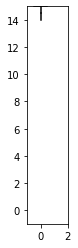

In [849]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,2])
    ax.set_ylim([-1,15])
    
    #plot body
    body_xb = m.q[i,'x'].value - 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yb = m.q[i,'y'].value - 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)
    body_xf = m.q[i,'x'].value + 0.5*m.len[('body',1)]*cos(m.q[i,'theta_b'].value)
    body_yf = m.q[i,'y'].value + 0.5*m.len[('body',1)]*sin(m.q[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black')
      
    #plot leg 1
    thA = m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value
    leg1_xt = m.q[i,'x'].value
    leg1_yt = m.q[i,'y'].value
    leg1_xb = m.q[i,'x'].value - m.len[('leg',1)]*cos(thA)
    leg1_yb = m.q[i,'y'].value - m.len[('leg',1)]*sin(thA)
    ax.plot([leg1_xt,leg1_xb],[leg1_yt,leg1_yb],color='xkcd:black')
    
    #plot leg 2
    thB= m.q[i,'theta_b'].value+m.q[i,'theta_lu'].value+m.q[i,'theta_ll'].value
    leg2_xt = leg1_xb
    leg2_yt = leg1_yb
    leg2_xb = leg1_xb-m.len[('leg',2)]*cos(thB)    
    leg2_yb = leg1_yb-m.len[('leg',2)]*sin(thB)     
    ax.plot([leg2_xt,leg2_xb],[leg2_yt,leg2_yb],color='xkcd:black')
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

In [851]:
for n in range(1,N+1):
    #print(m.dq[n,'x'].value)                  #velocity
    #print(m.dq[n,'y'].value)               #velocity
    #print(m.dq[n,'theta_b'].value)            #velocity
    #print(m.dq[n,'theta_lu'].value)          #velocity
    #print(m.dq[n,'theta_ll'].value)            #velocity
    

    #print(m.ddq[n,'x'].value)                  #acceleration
    #print(m.ddq[n,'y'].value)               #acceleration
    #print(m.ddq[n,'theta_b'].value)            #acceleration
    #print(m.ddq[n,'theta_lu'].value)          #acceleration
    #print(m.ddq[n,'theta_ll'].value)            #acceleration
    
    #print(m.tau_a[n].value)            #torque hip
    #print(m.tau_b[n].value)            #torque knee

SyntaxError: unexpected EOF while parsing (<ipython-input-851-a1629fe56c19>, line 16)

In [850]:
sym.printing.latex(EOM[1].simplify())

'- 1.0 G_{y} - 0.5 \\ddot{\\theta}_{body} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{body} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{body} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_lower} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg1} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 1.0 \\ddot{\\theta}_{leg_upper} l_{leg1} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_upper} \\right)} - 0.5 \\ddot{\\theta}_{leg_upper} l_{leg2} m_{leg2} \\cos{\\left(\\theta_{body} + \\theta_{leg_lower} + \\theta_{leg_upper} \\right)} + 1.0 \\ddot{y} m_{body} + 1.0 \\ddot{y} m_{leg1} + 1.0 \\ddot{y} m_{leg2} + 0.5 \\dot{\\theta}_{body}^{2} l_{leg1} m_{leg1} \\sin{\\left(\\theta_{body}